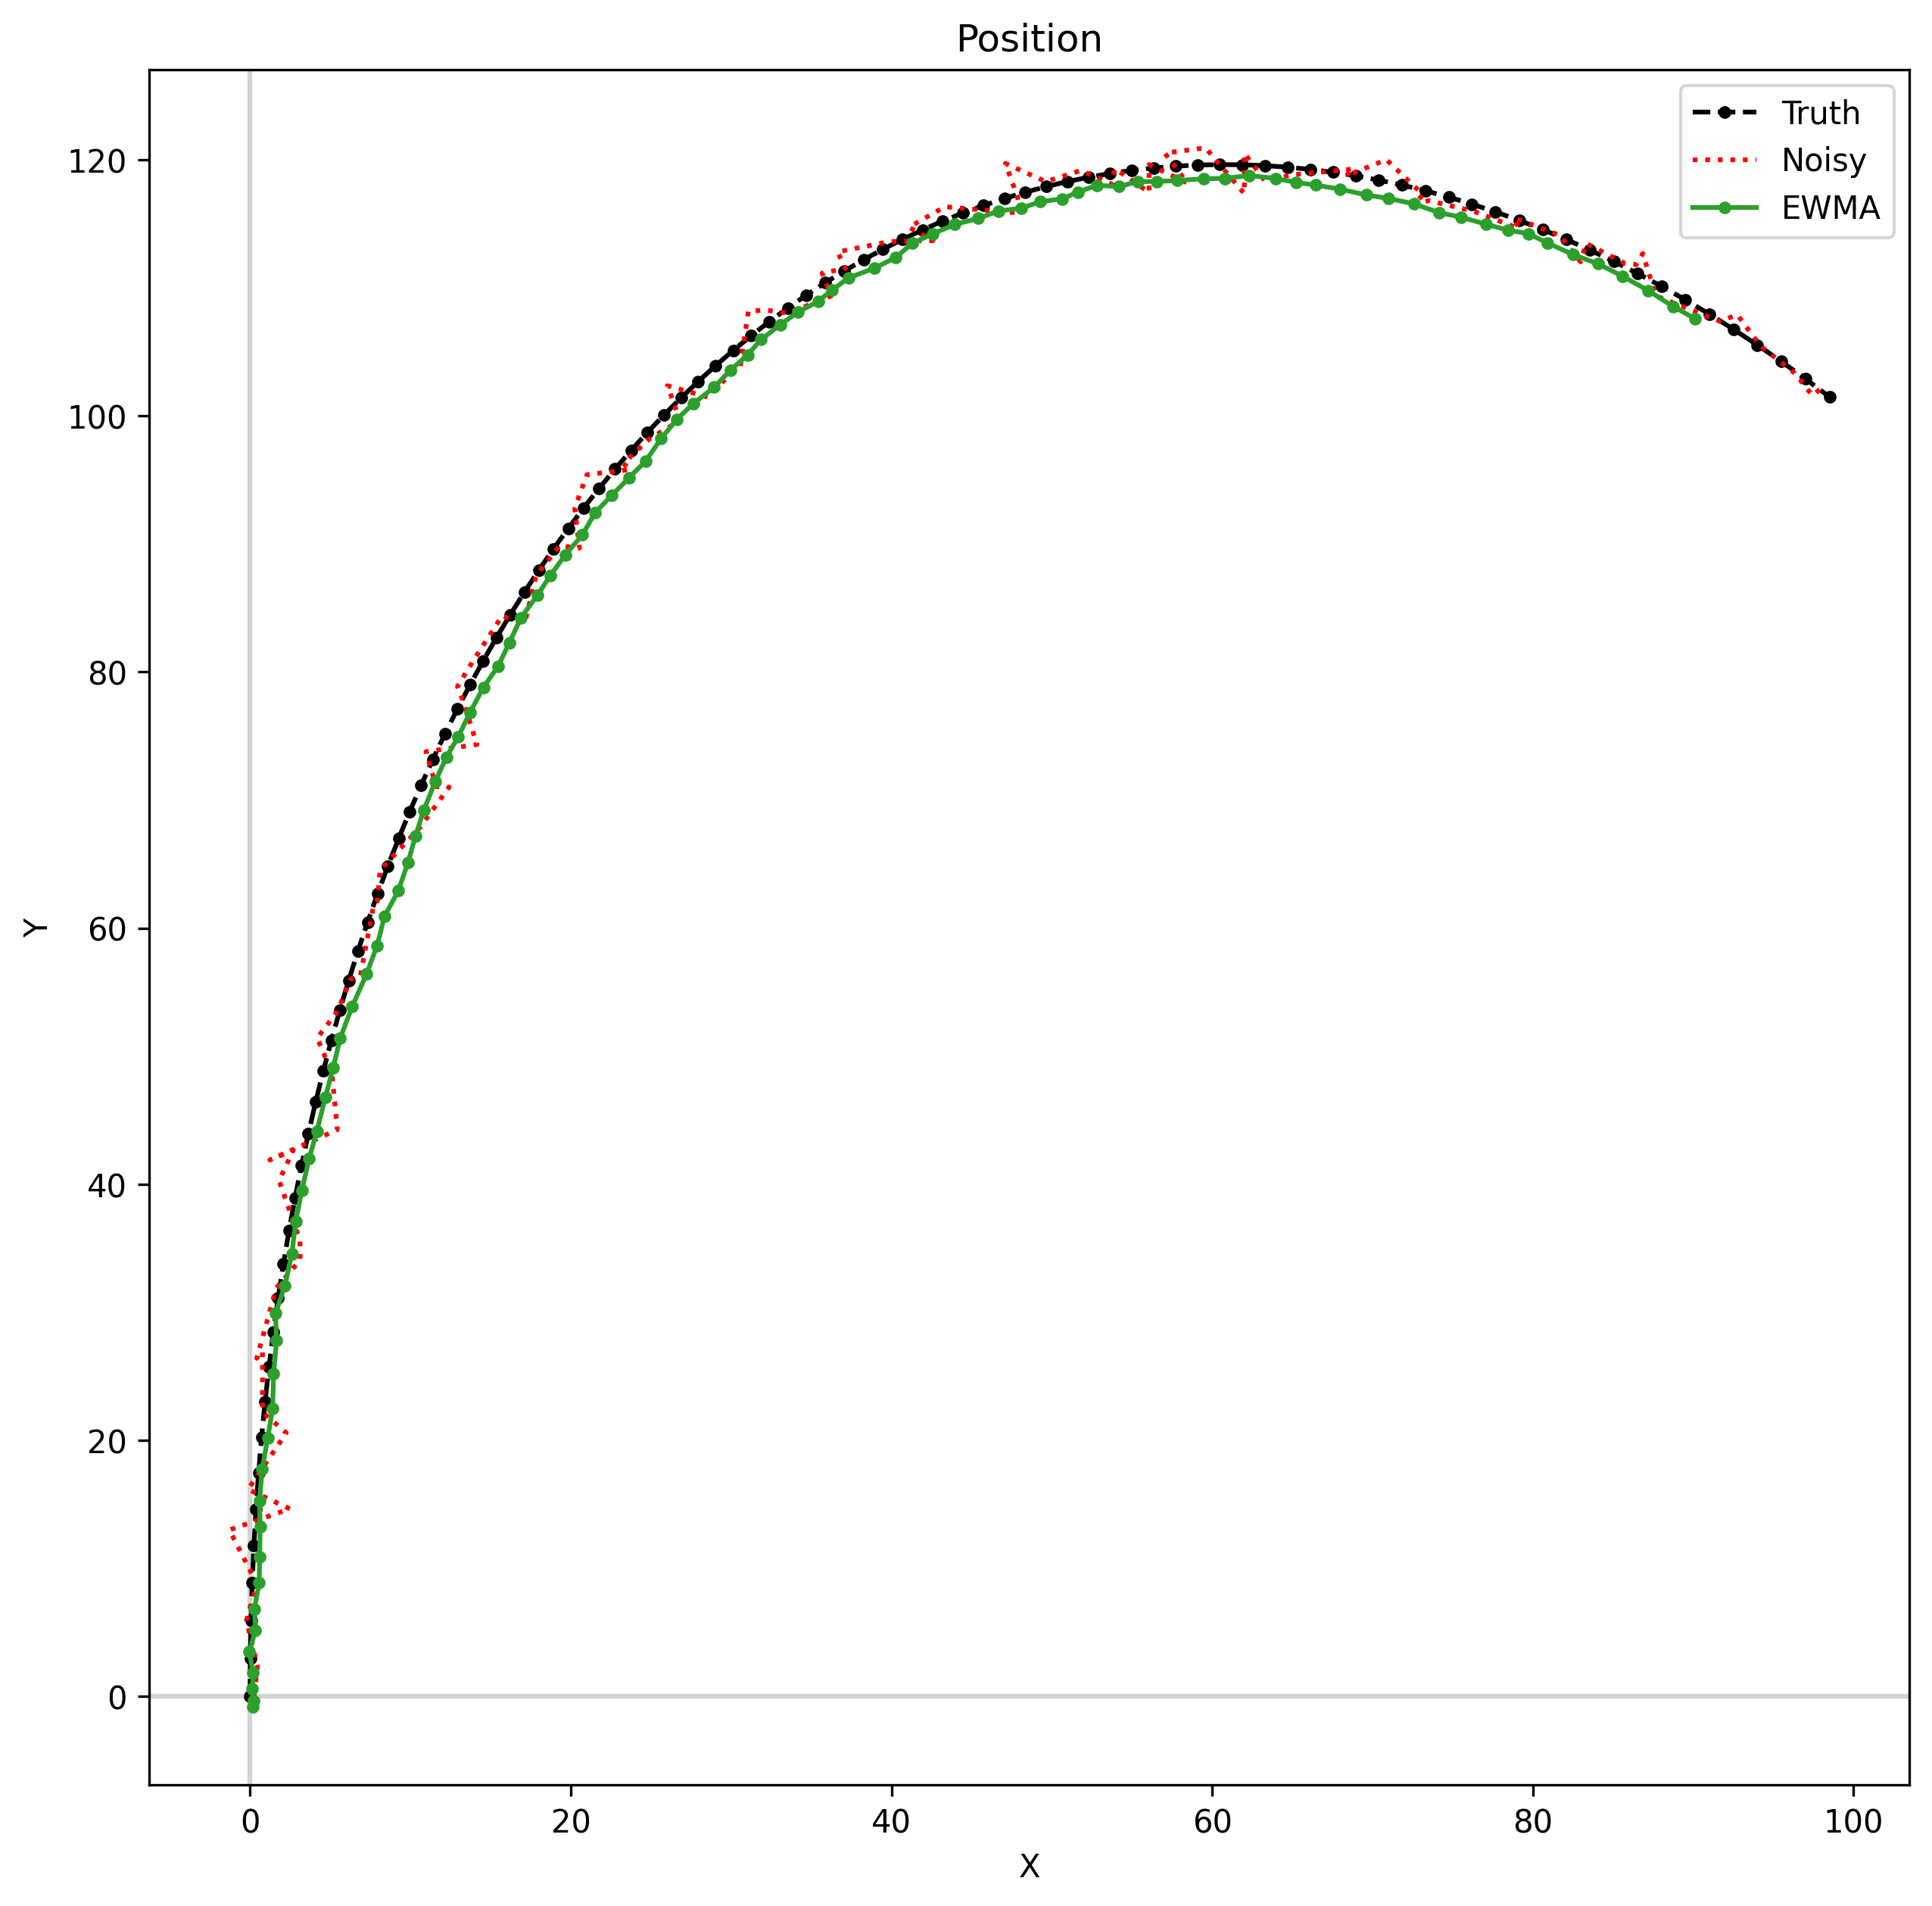

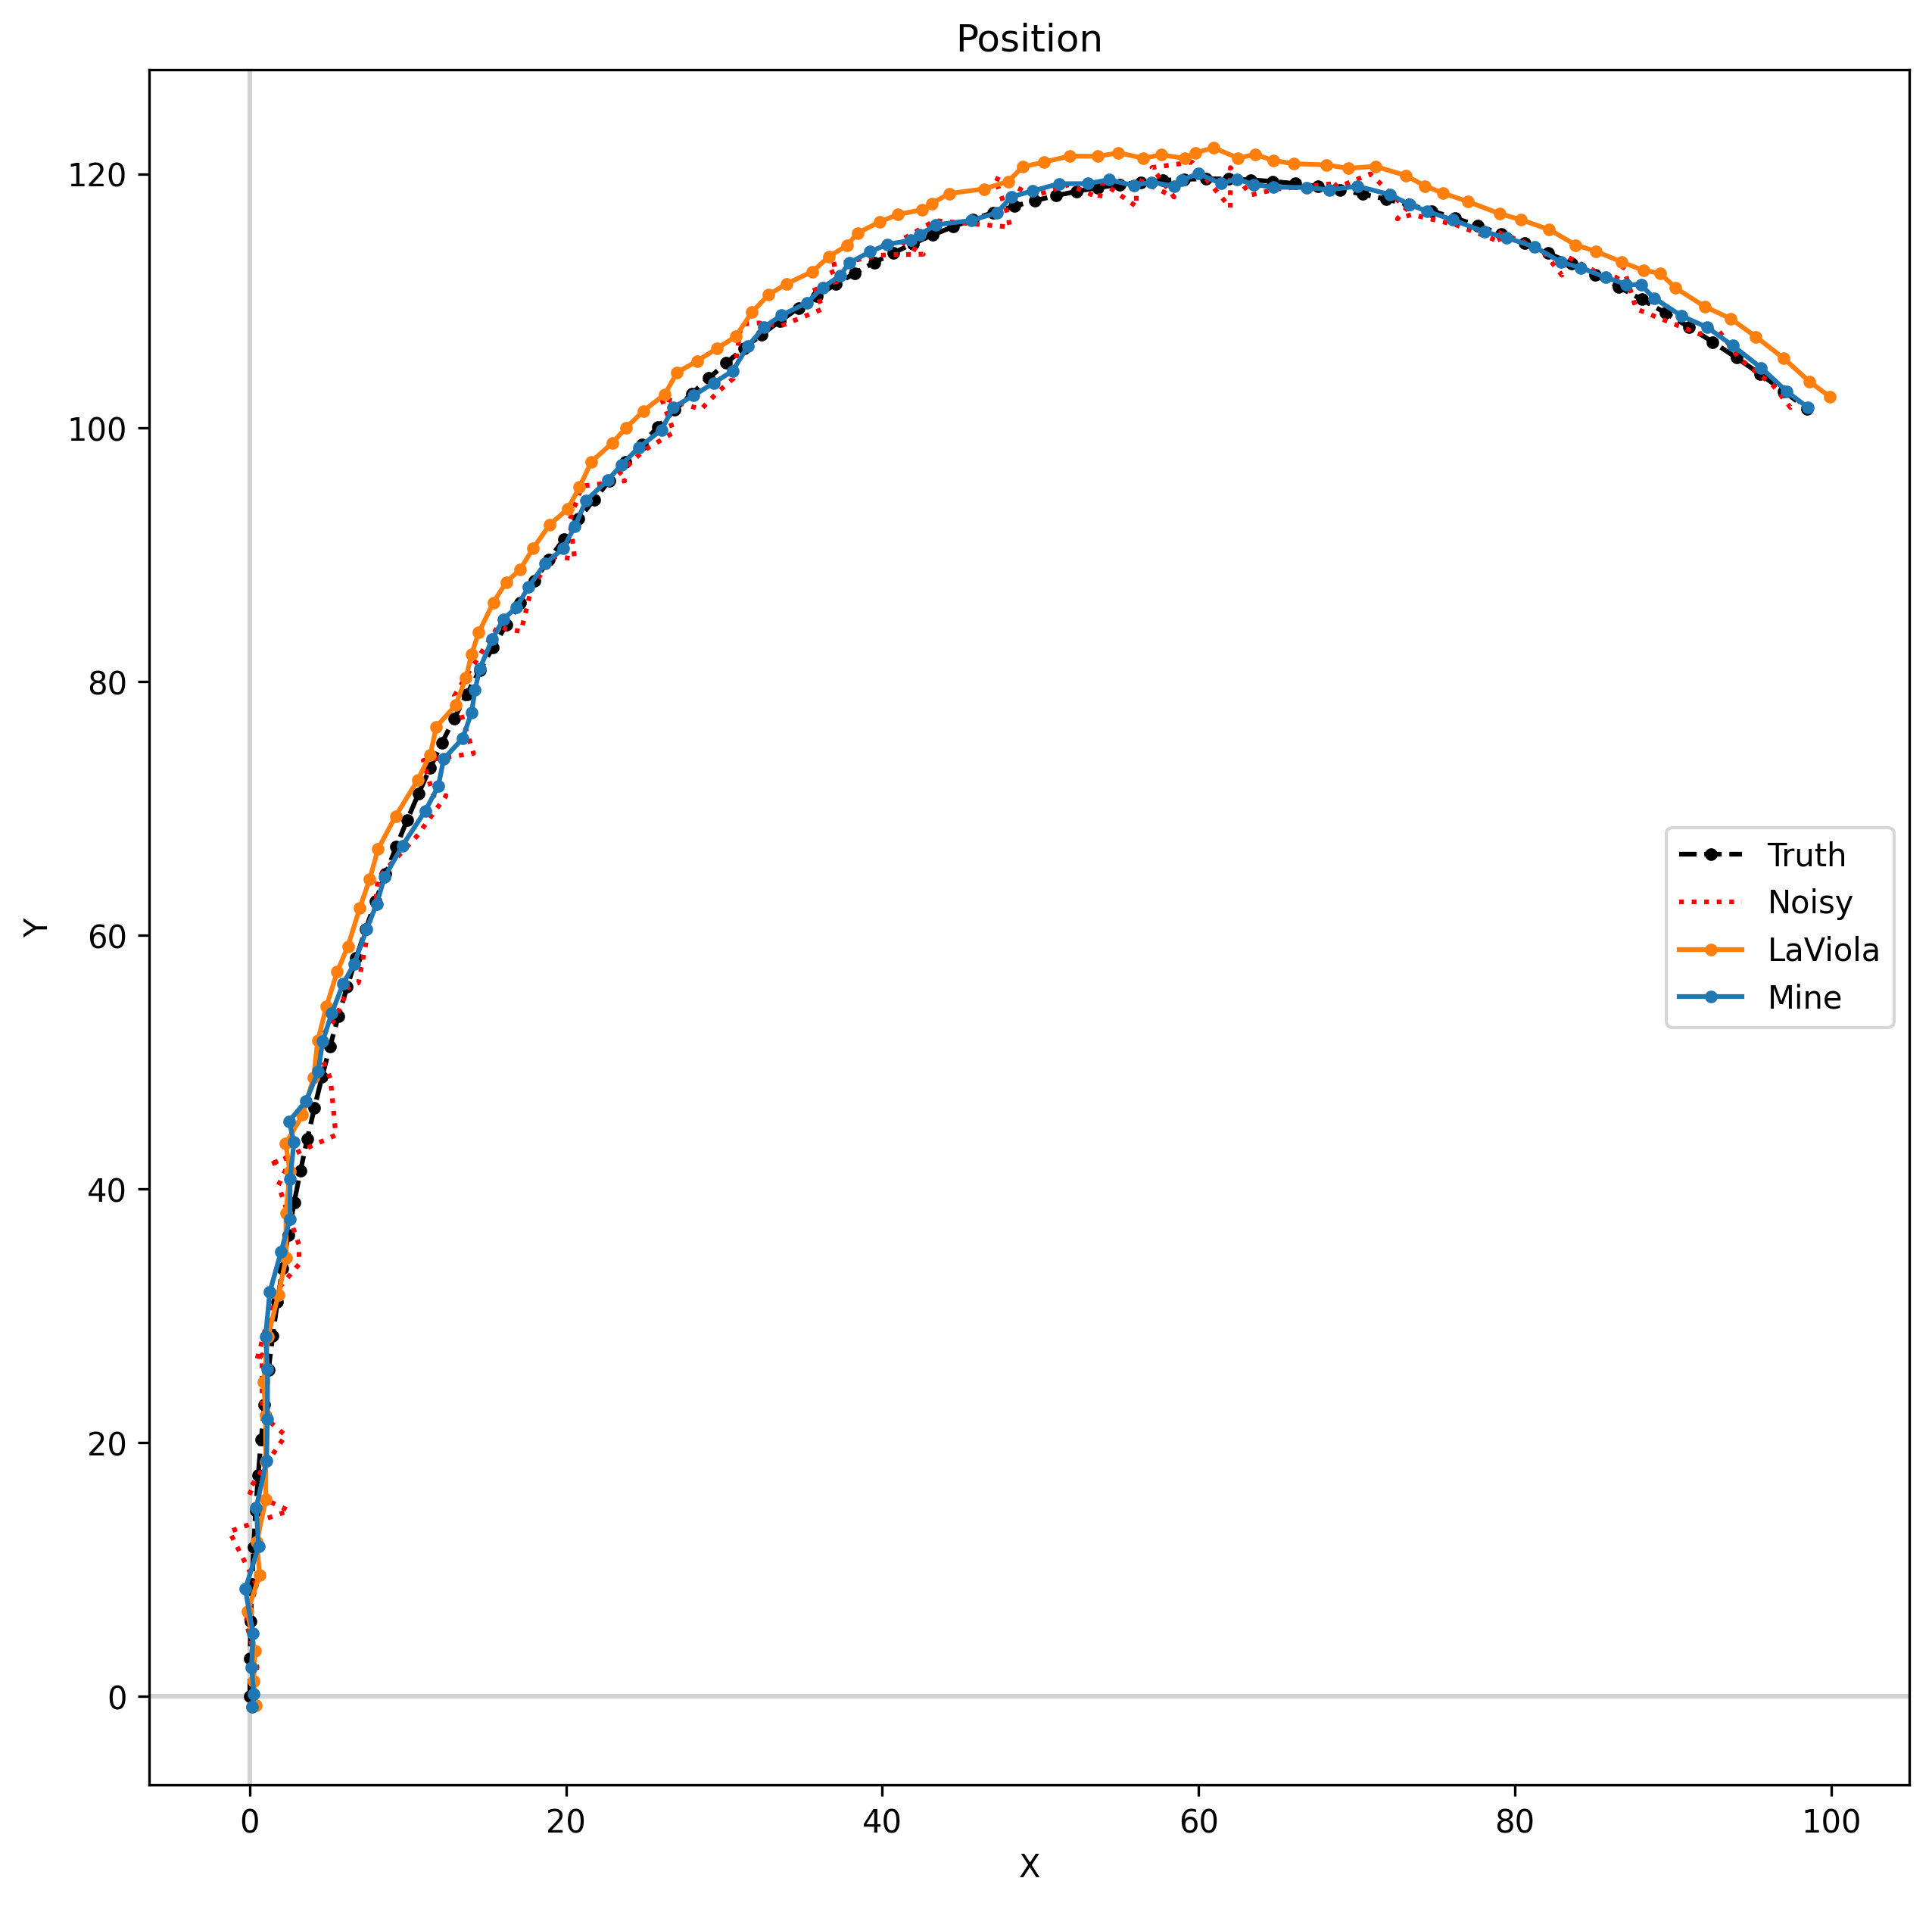

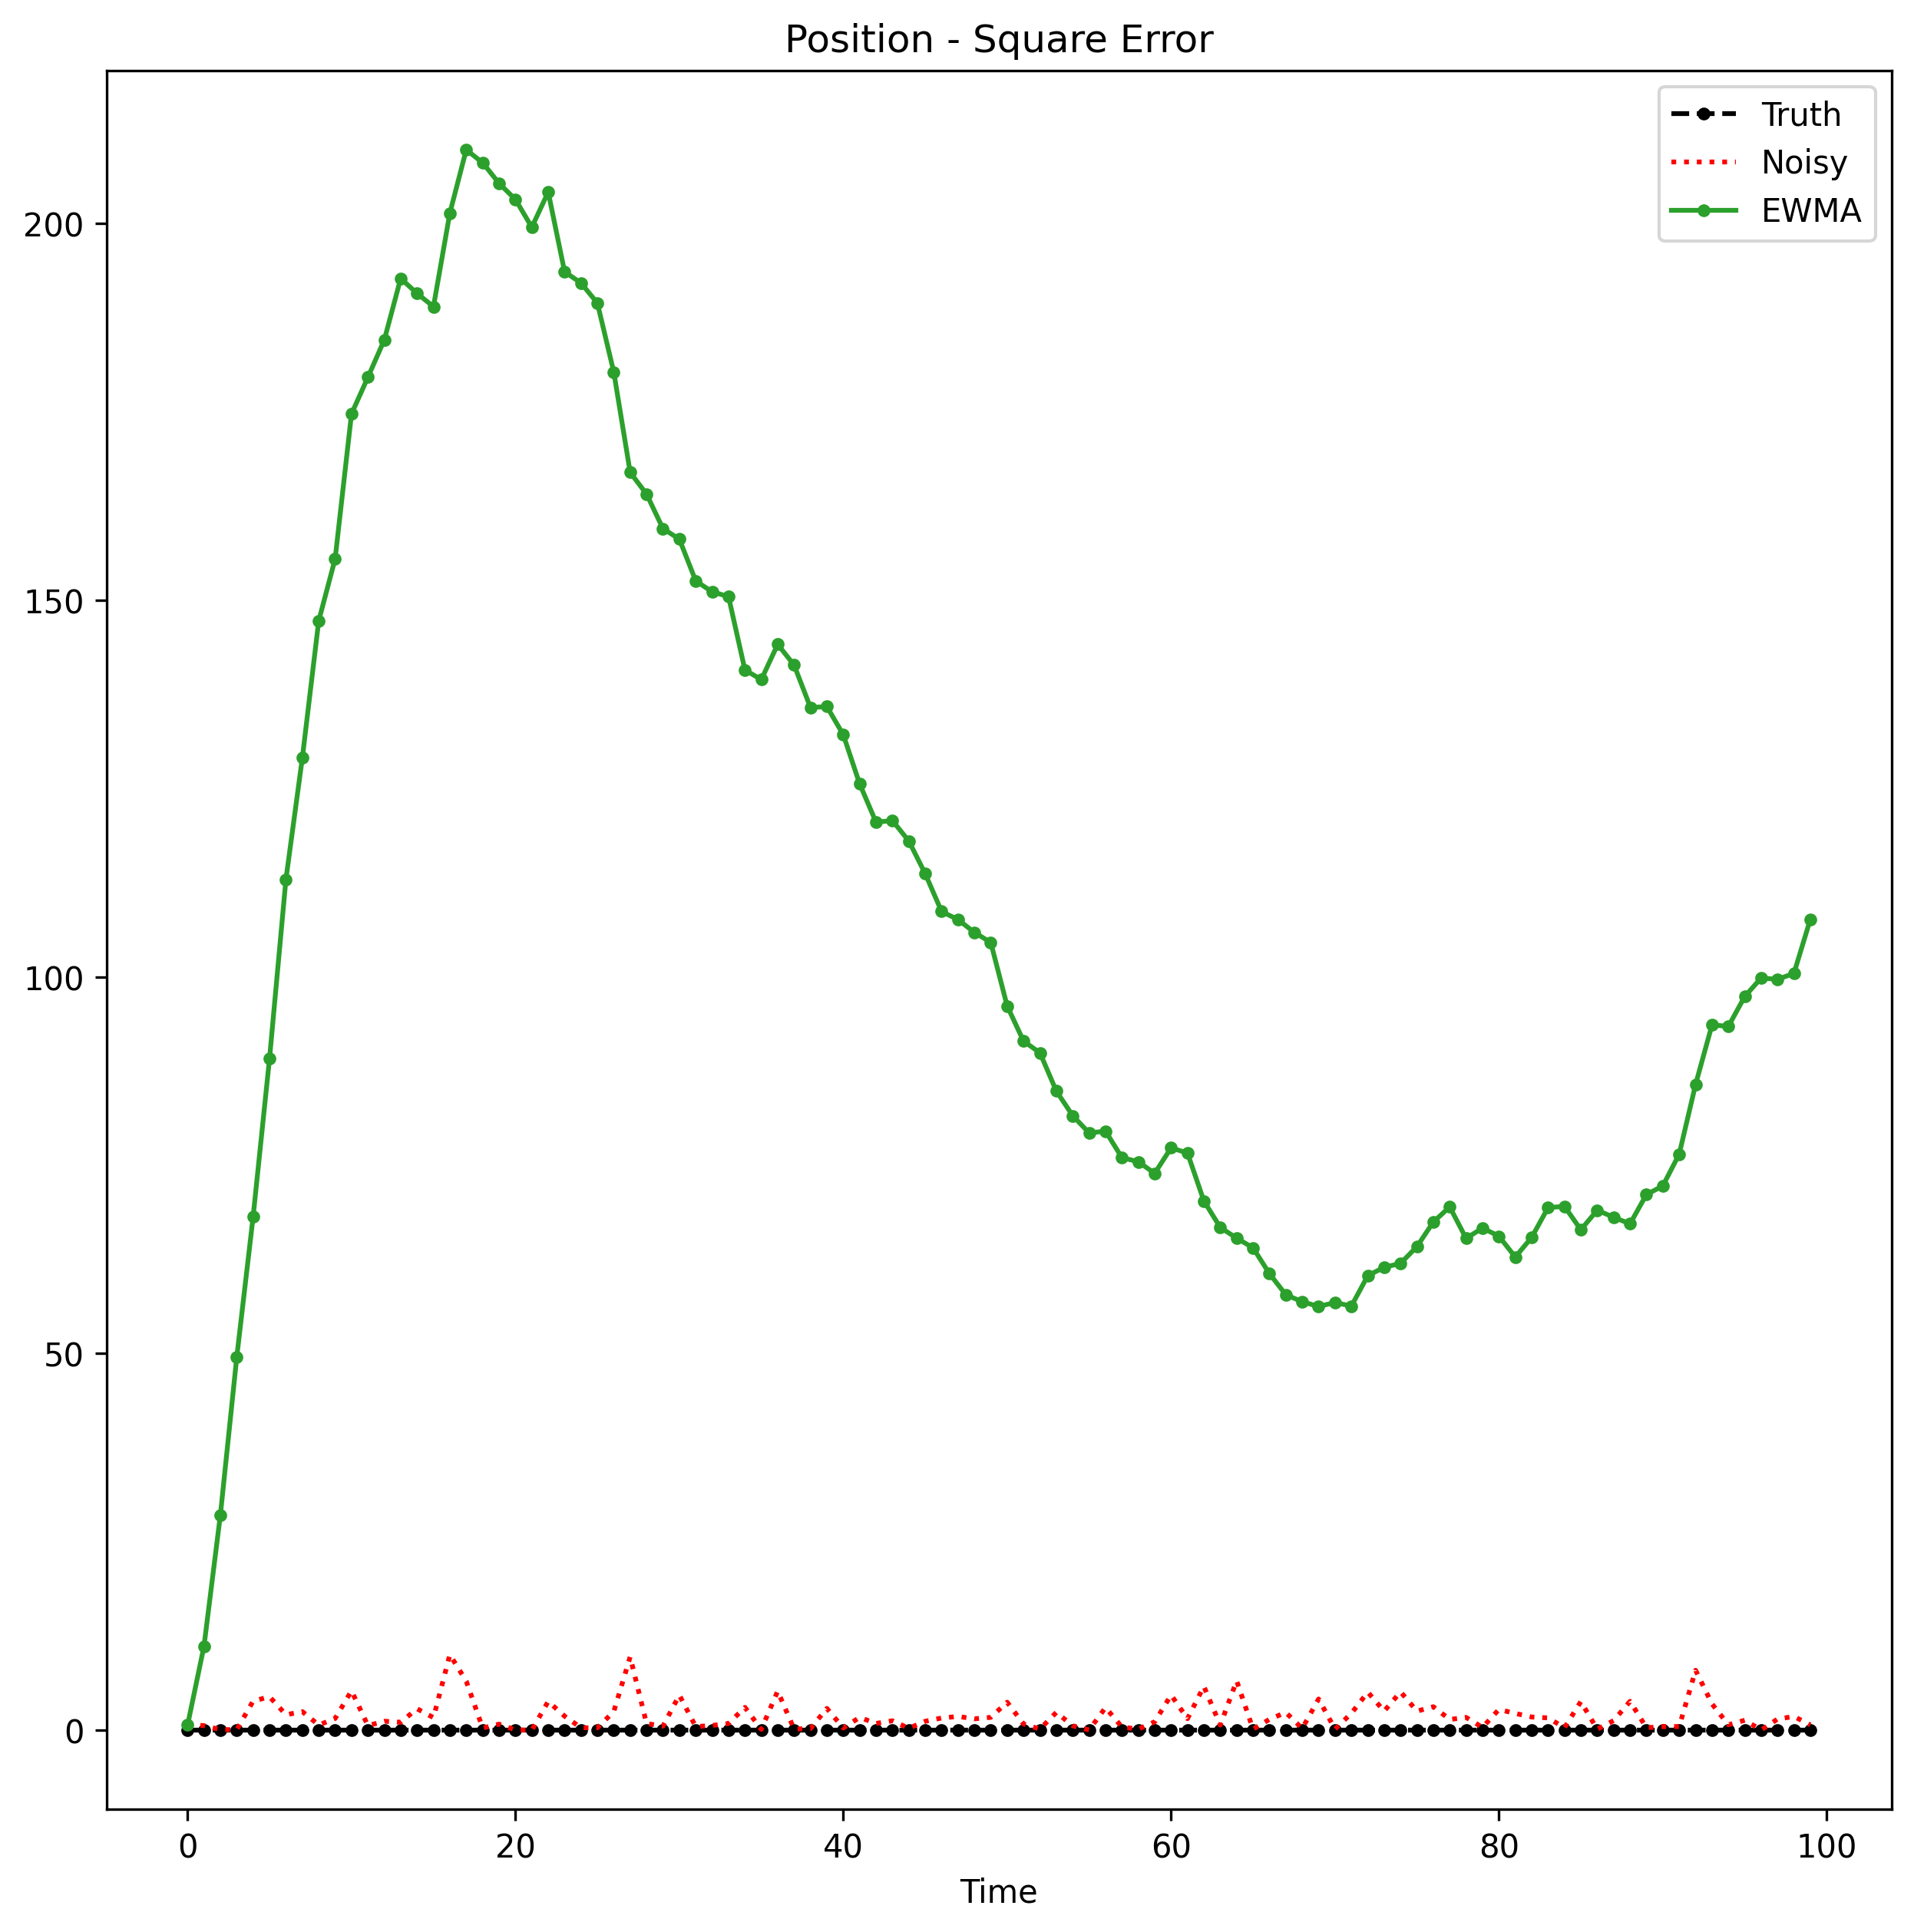

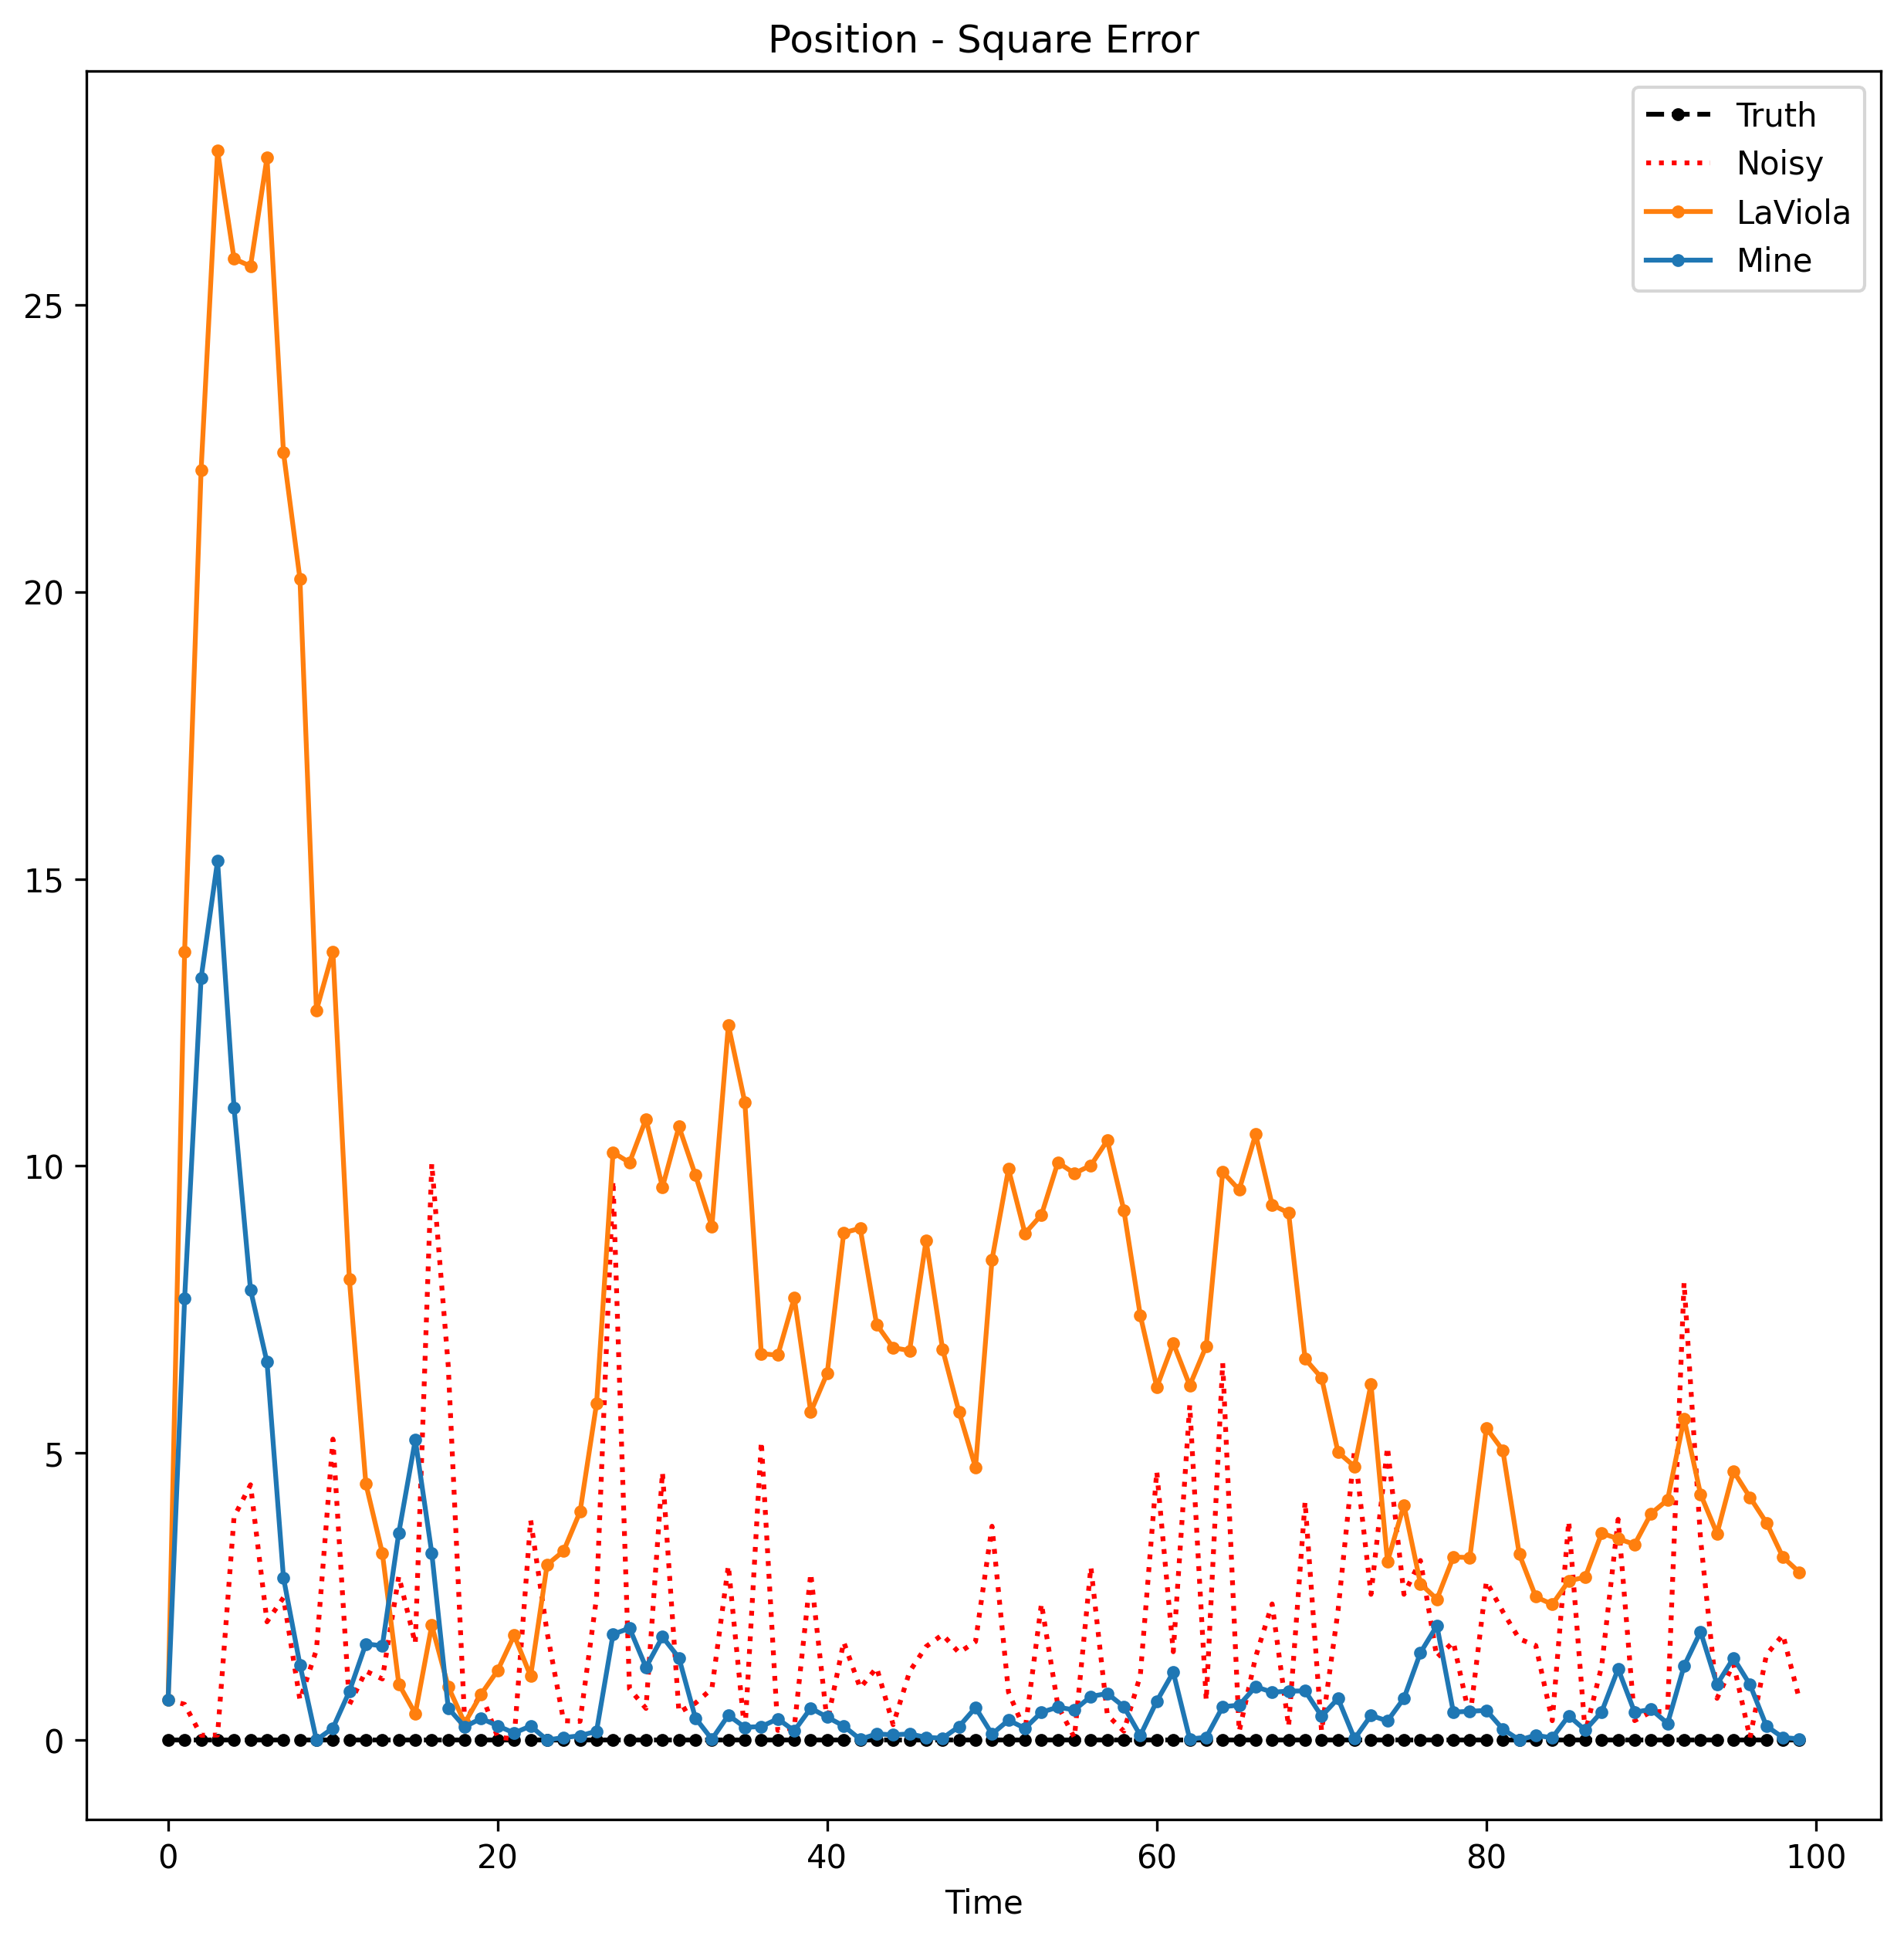

AVG SQUARE ERROR
NOISE: 1.9906476975609075
EWMA: 109.0010466656285
LAVIOLA: 7.362816753658568
MINE: 1.272443097832457

AVG SQUARE ERROR AFTER STABLE
NOISE: 2.026830236877068
EWMA: 112.3098291577186
LAVIOLA: 5.9739458708415185
MINE: 0.6742631984403877


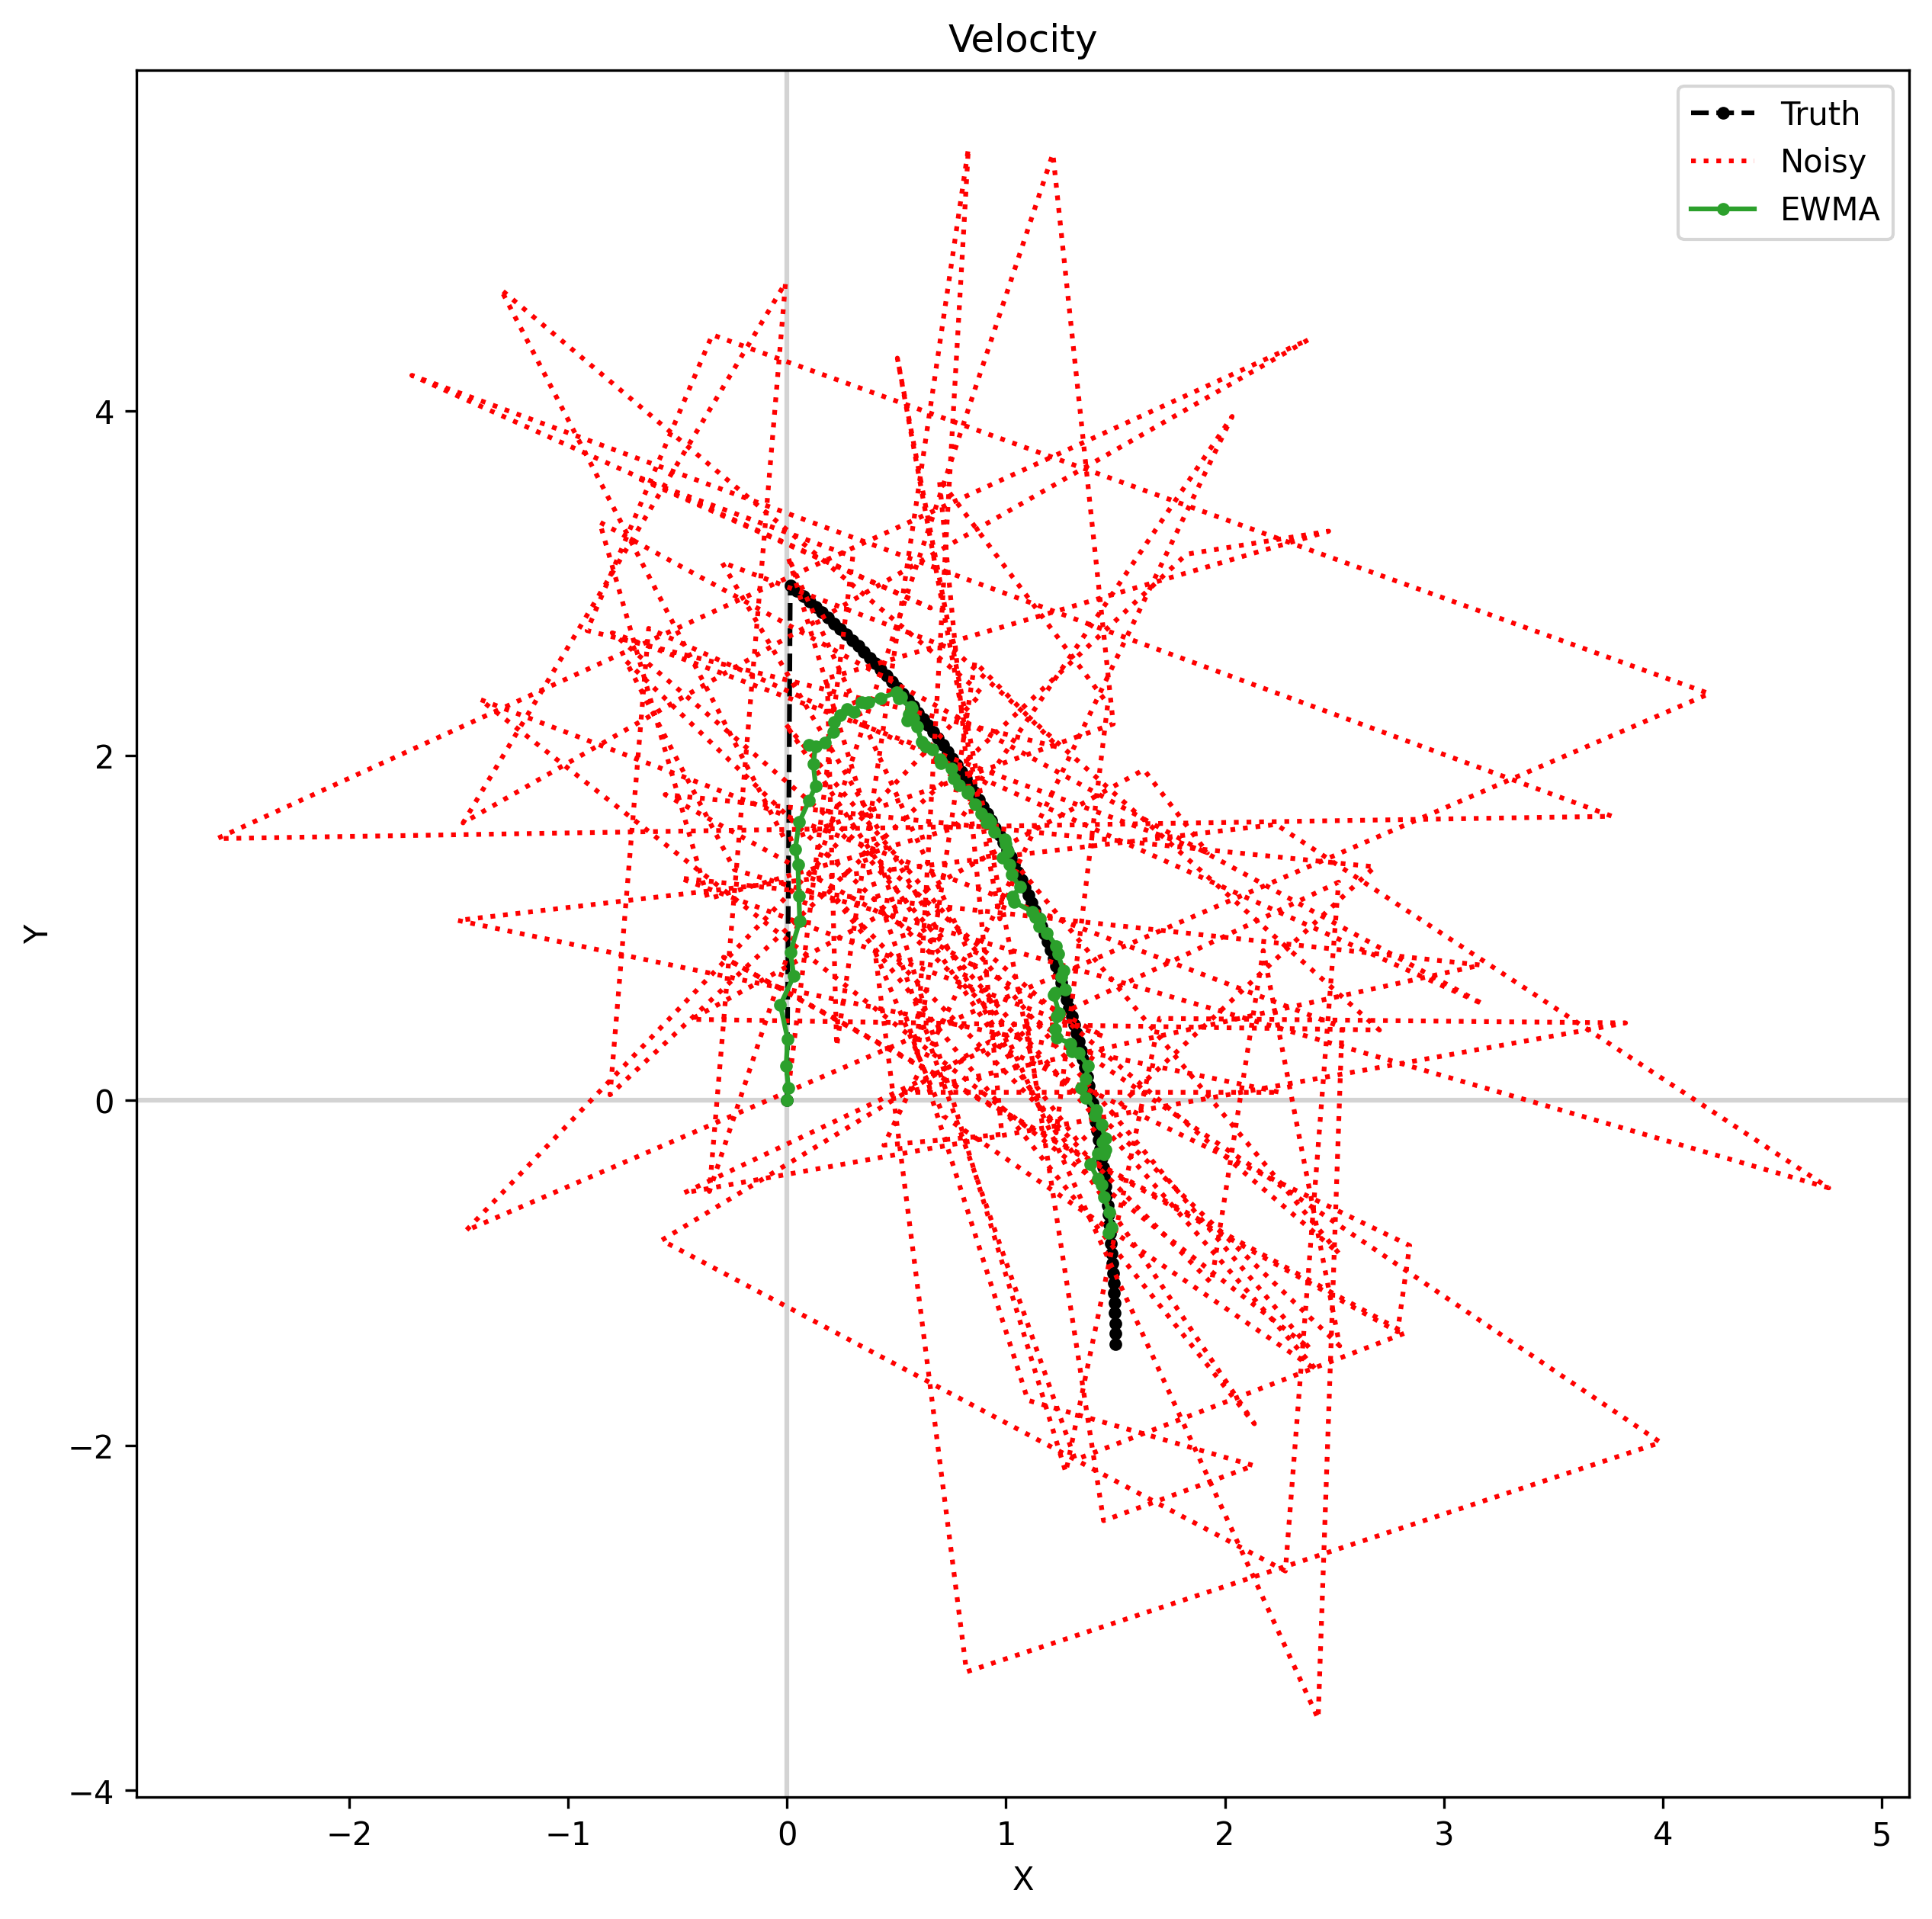

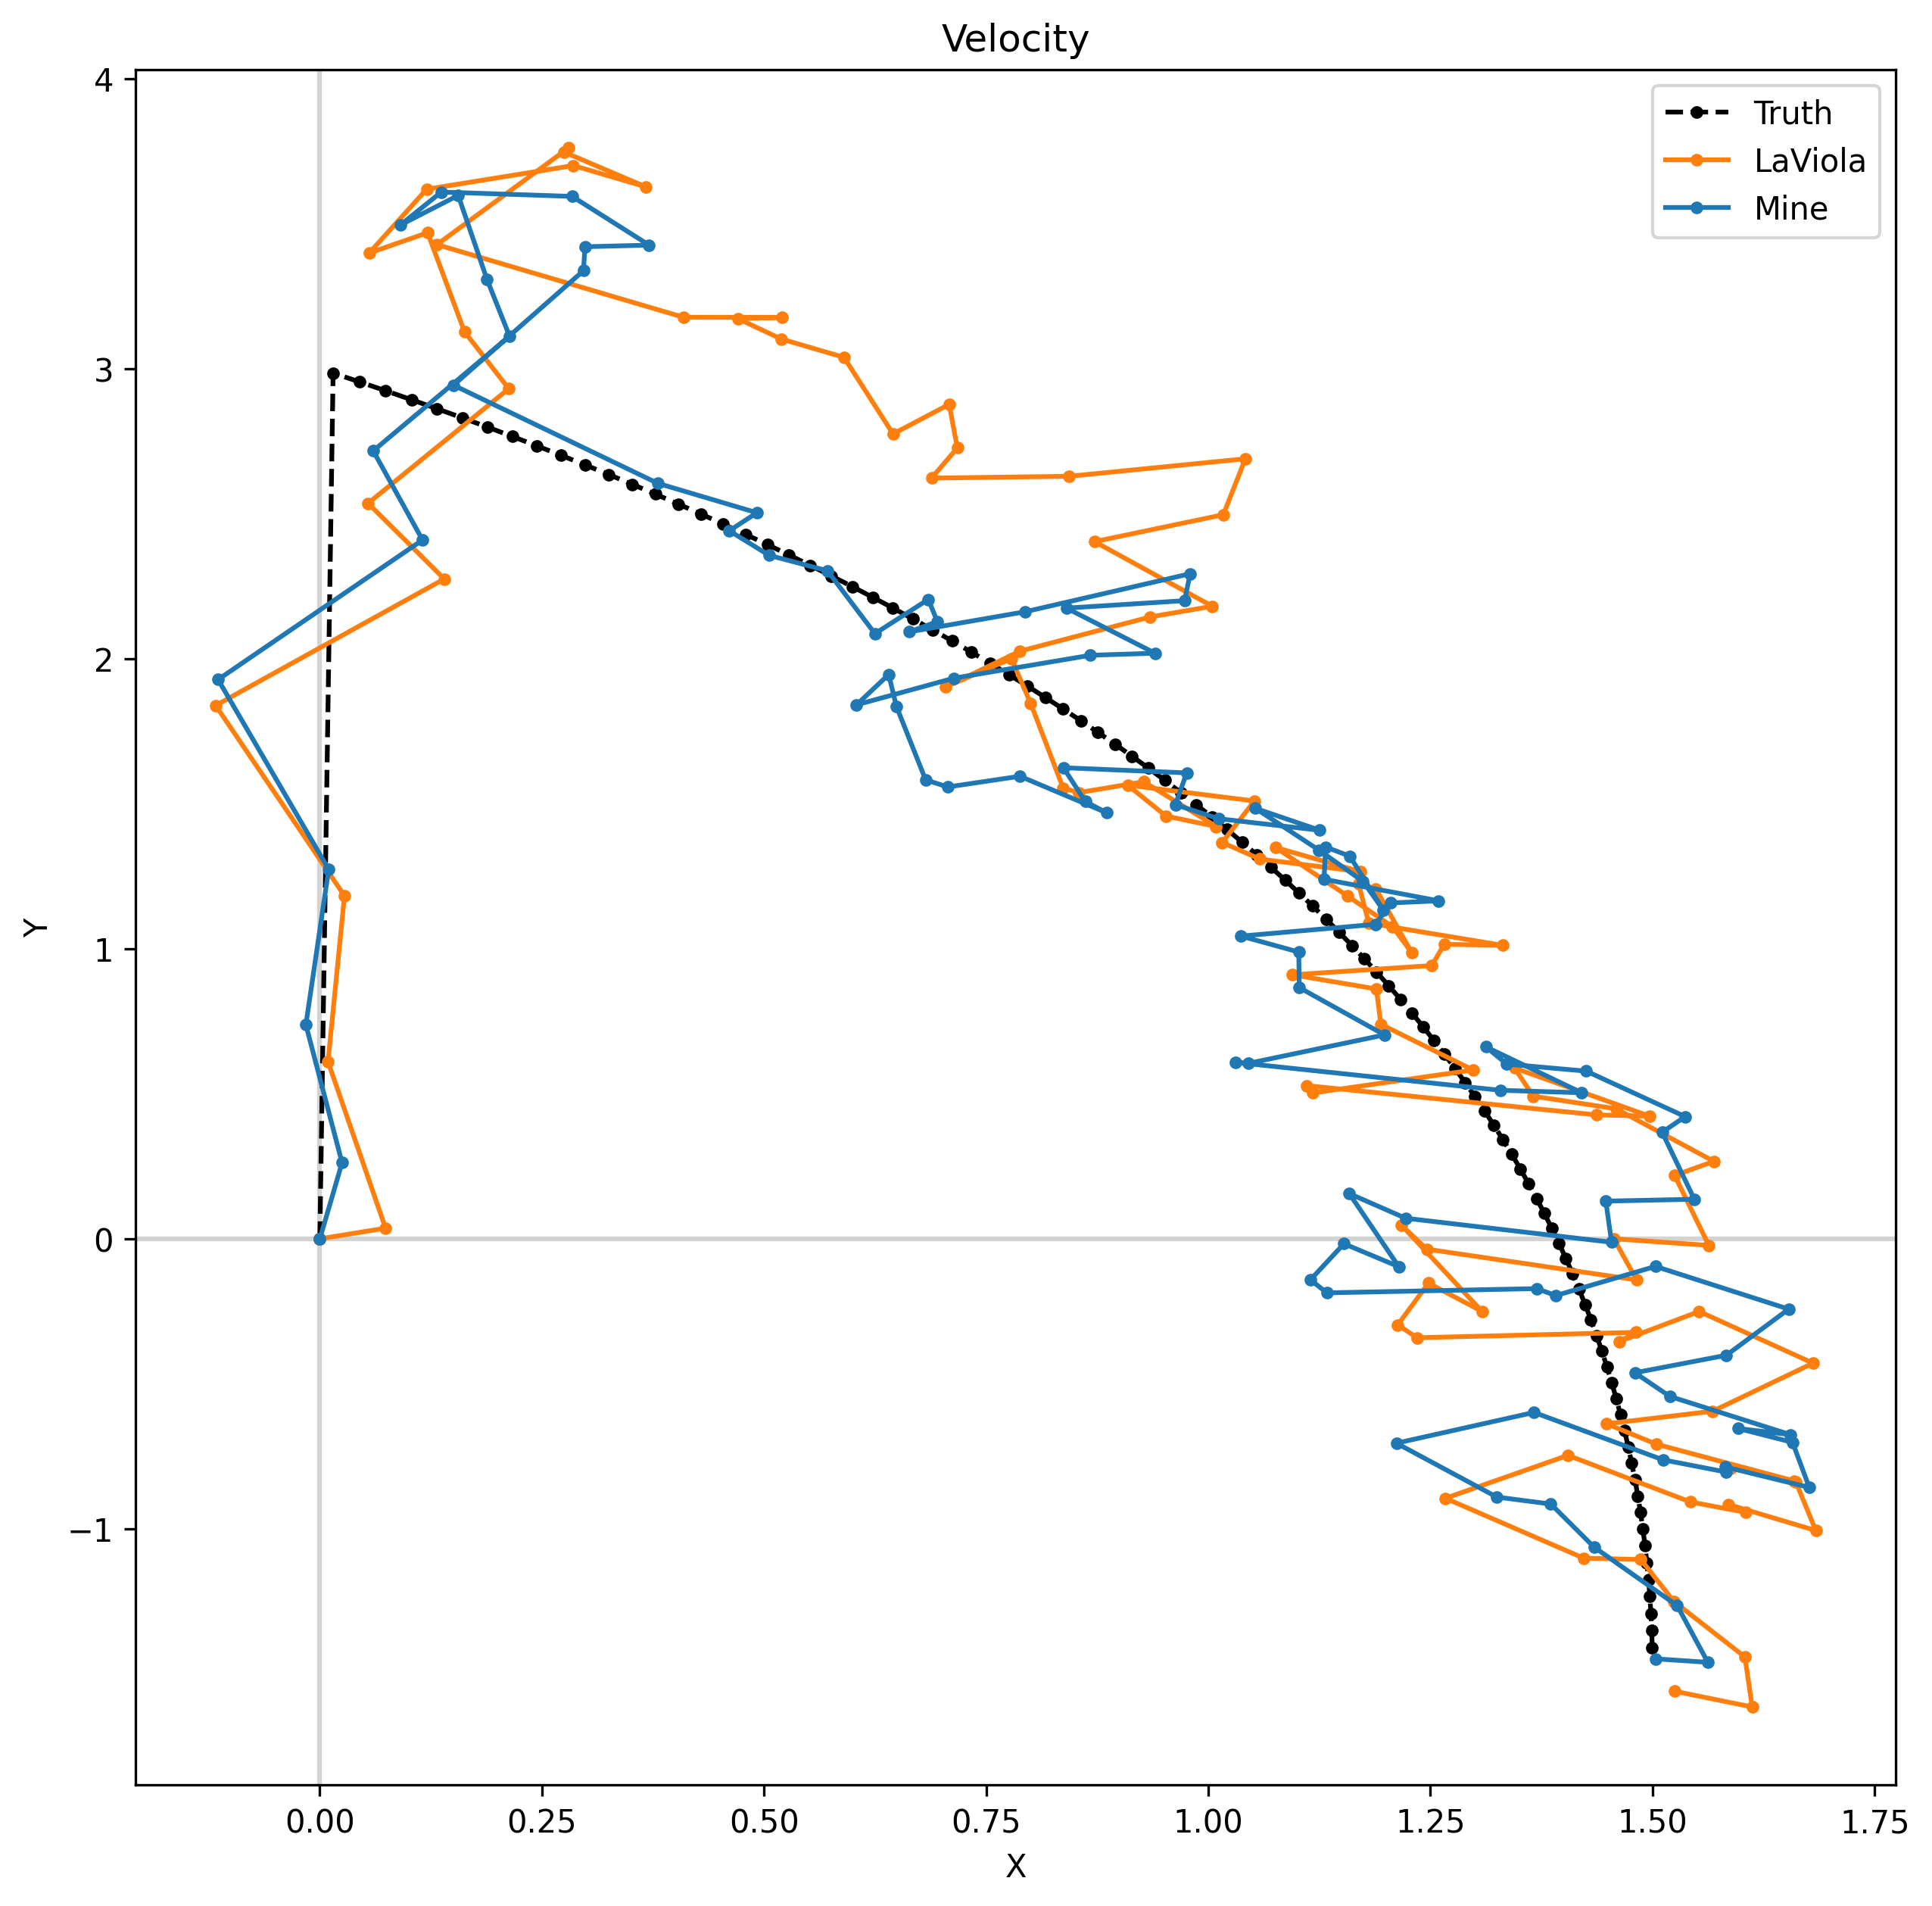

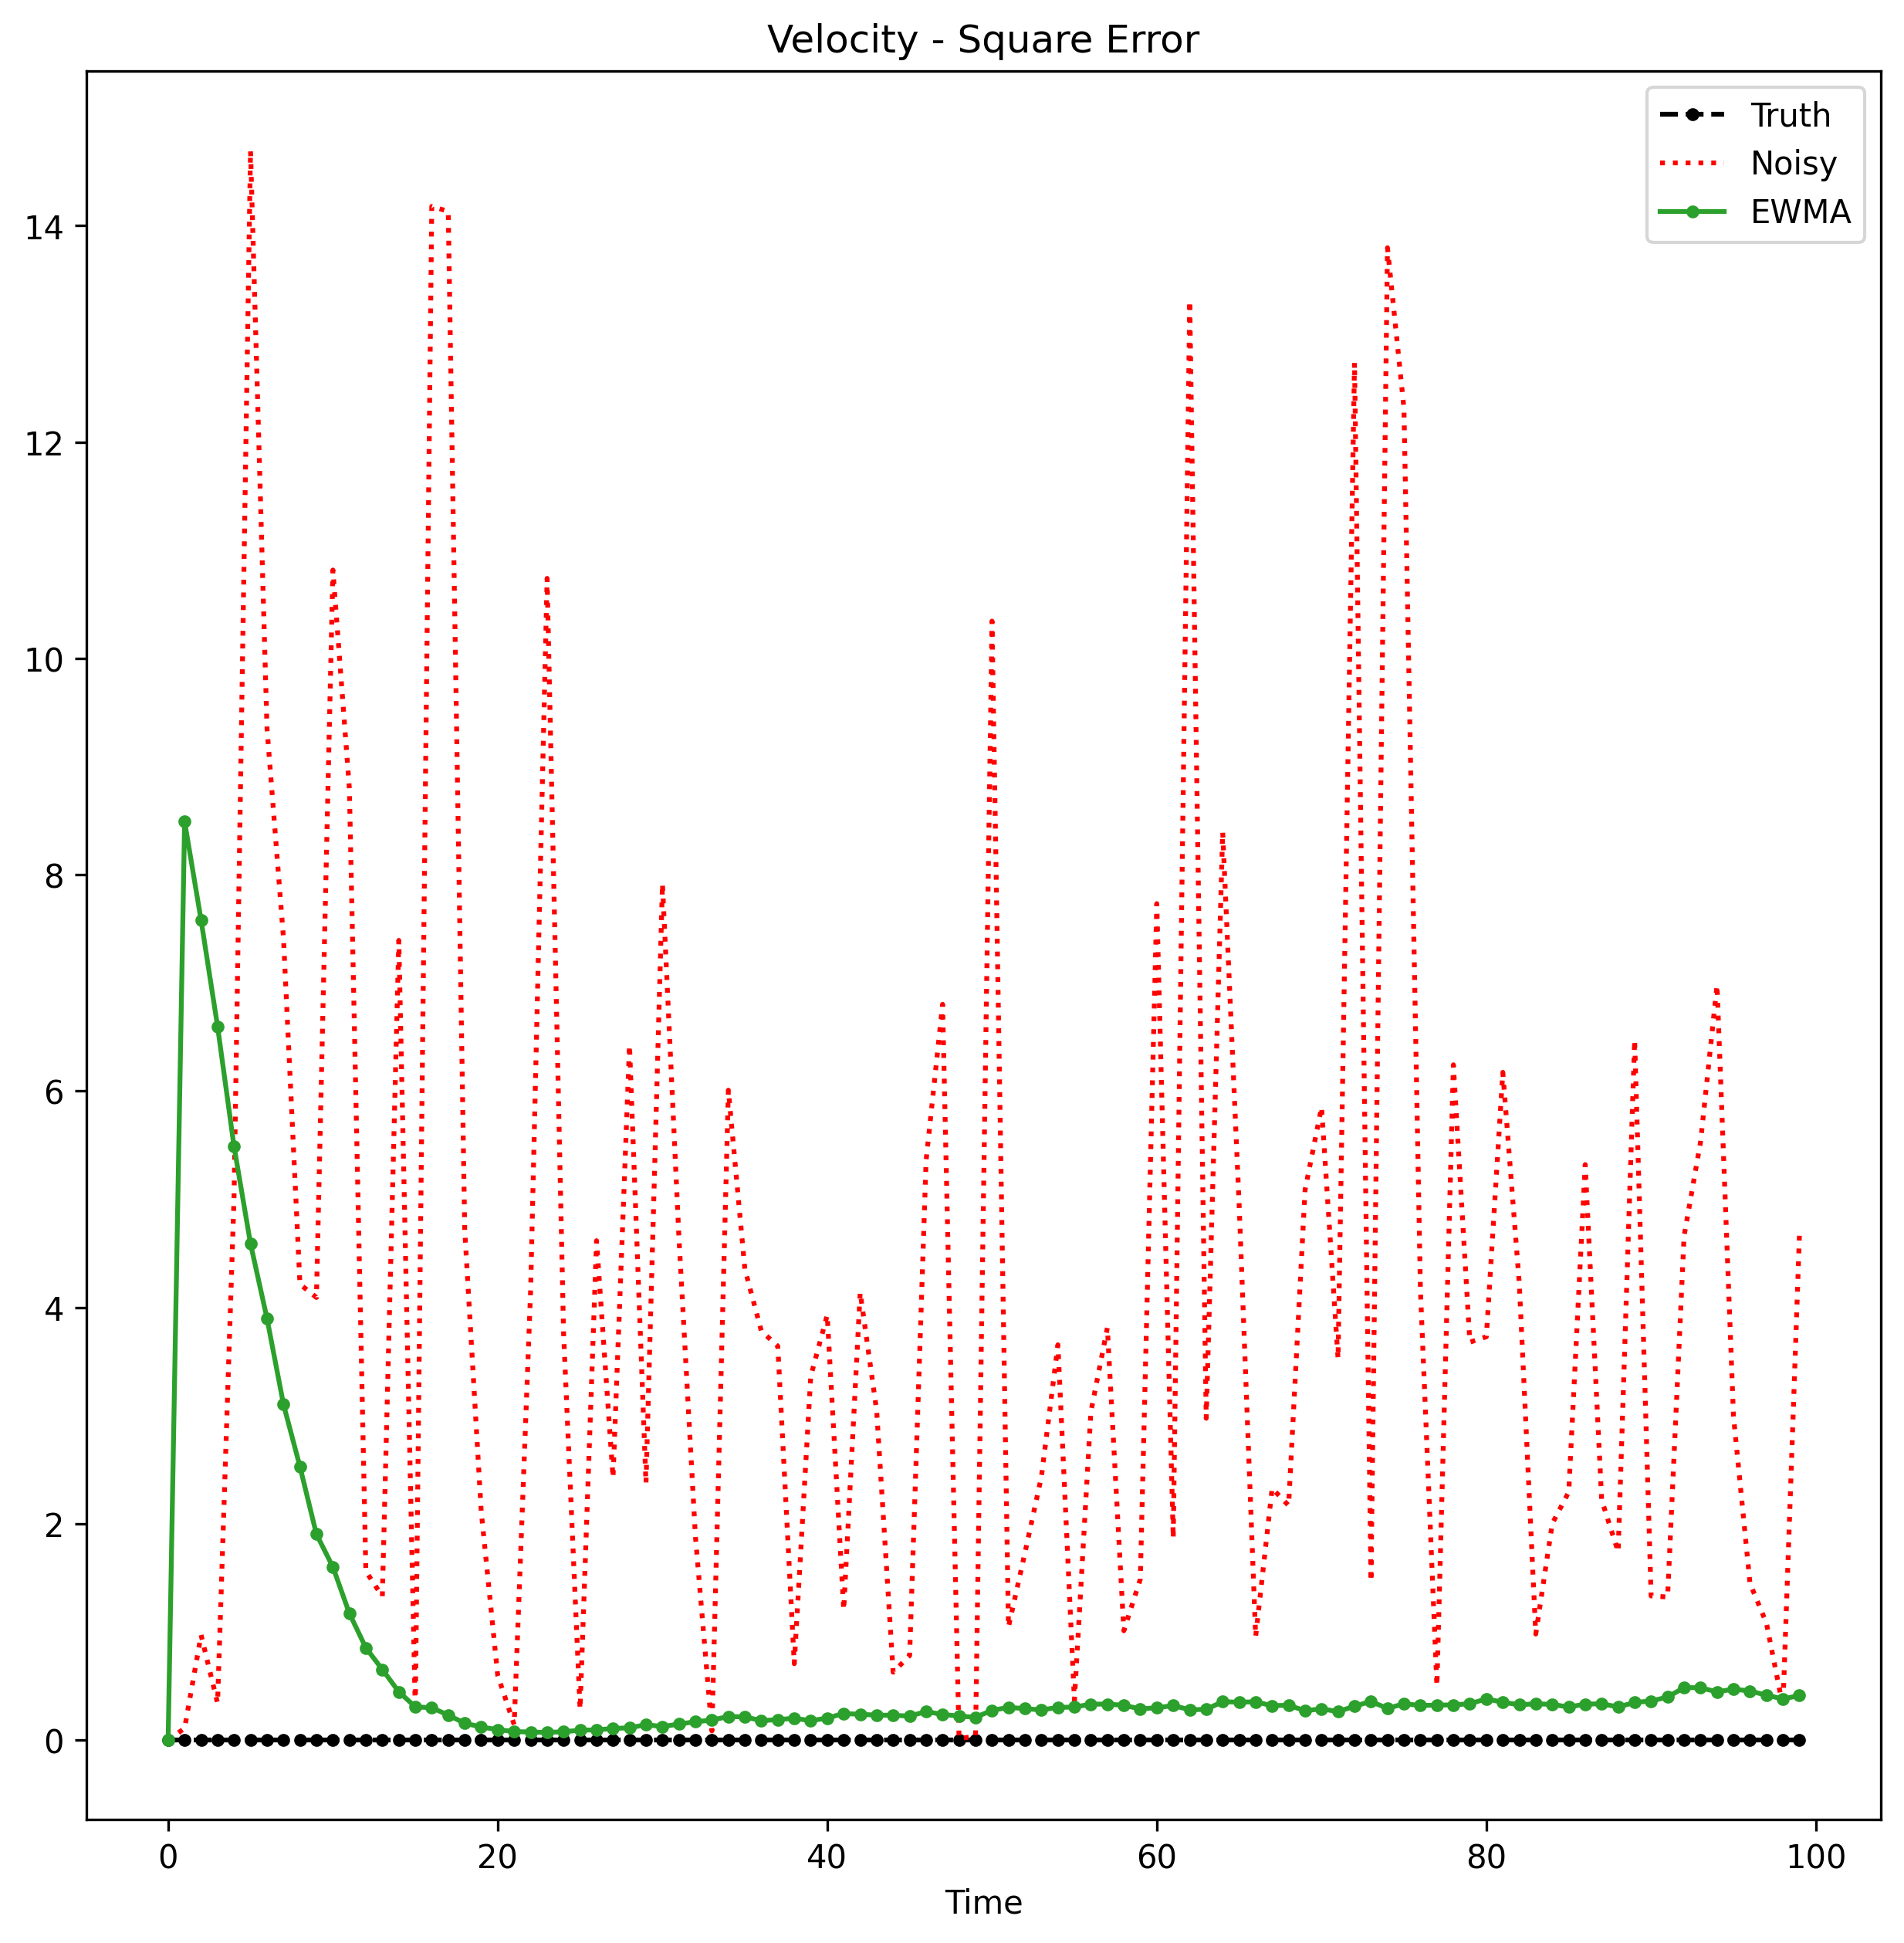

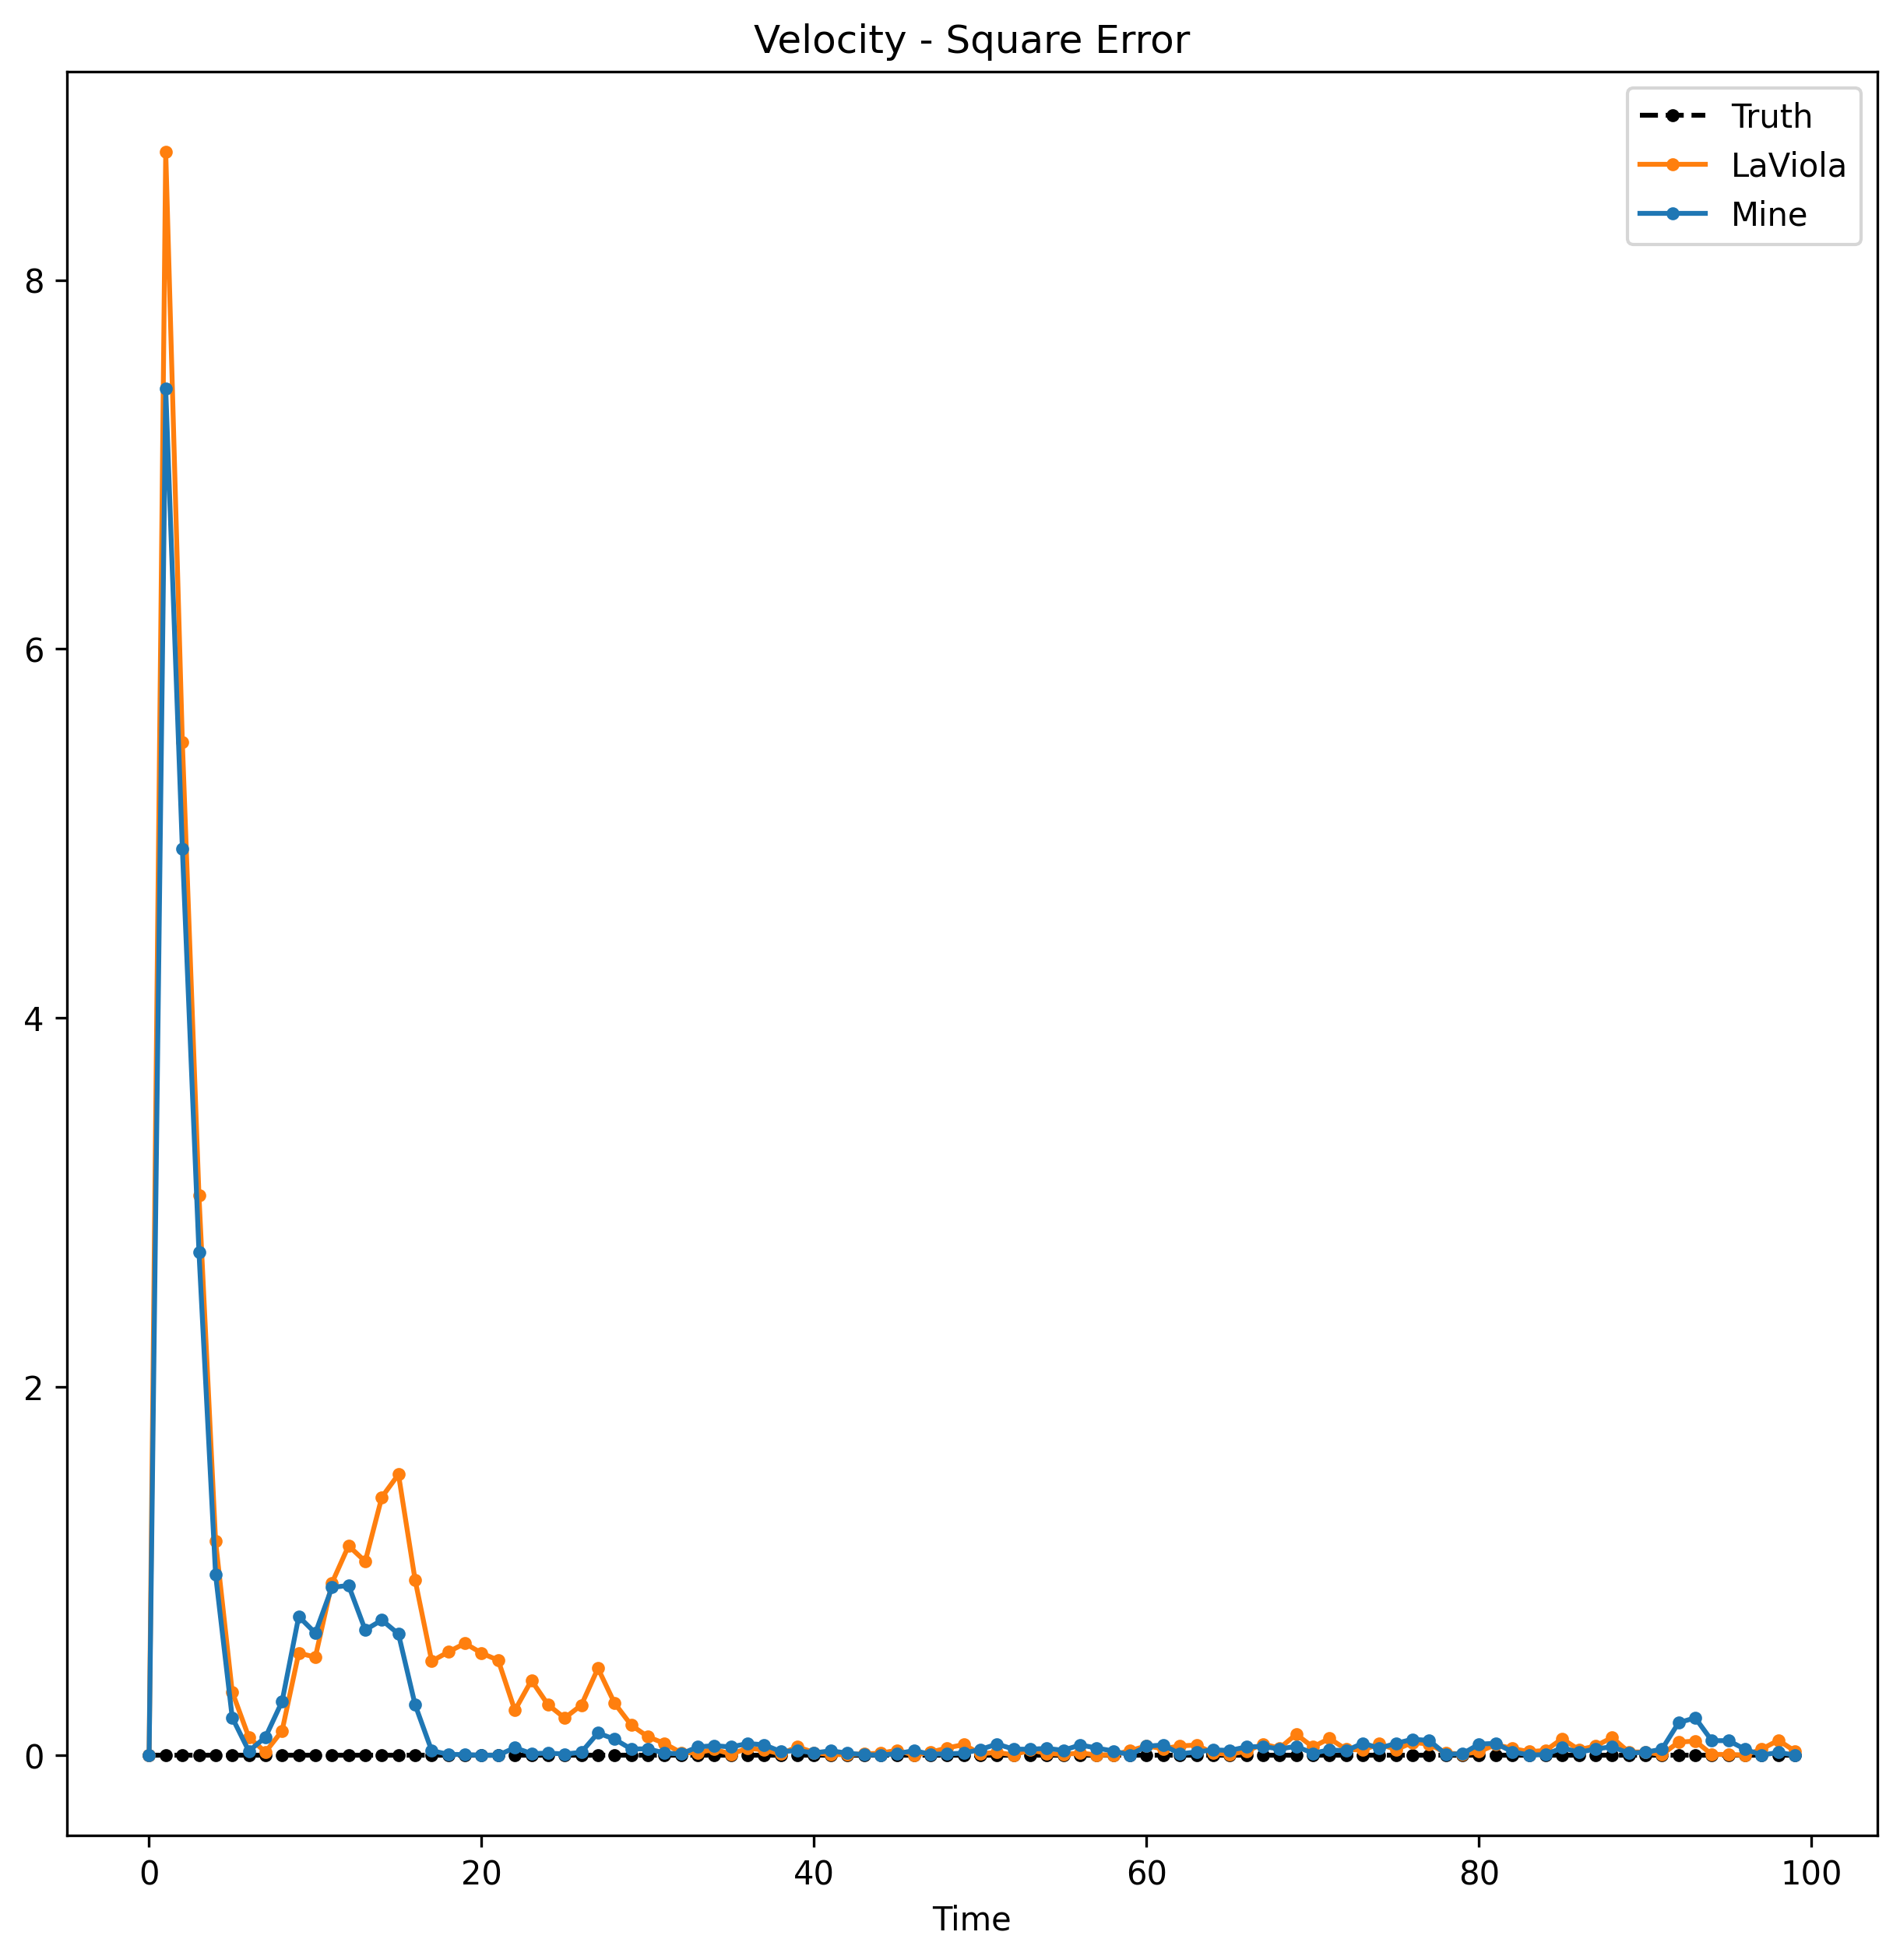

AVG SQUARE ERROR
NOISE: 4.178057868181141
EWMA: 0.7211848775227382
LAVIOLA: 0.3445424835495313
MINE: 0.2518065382038185


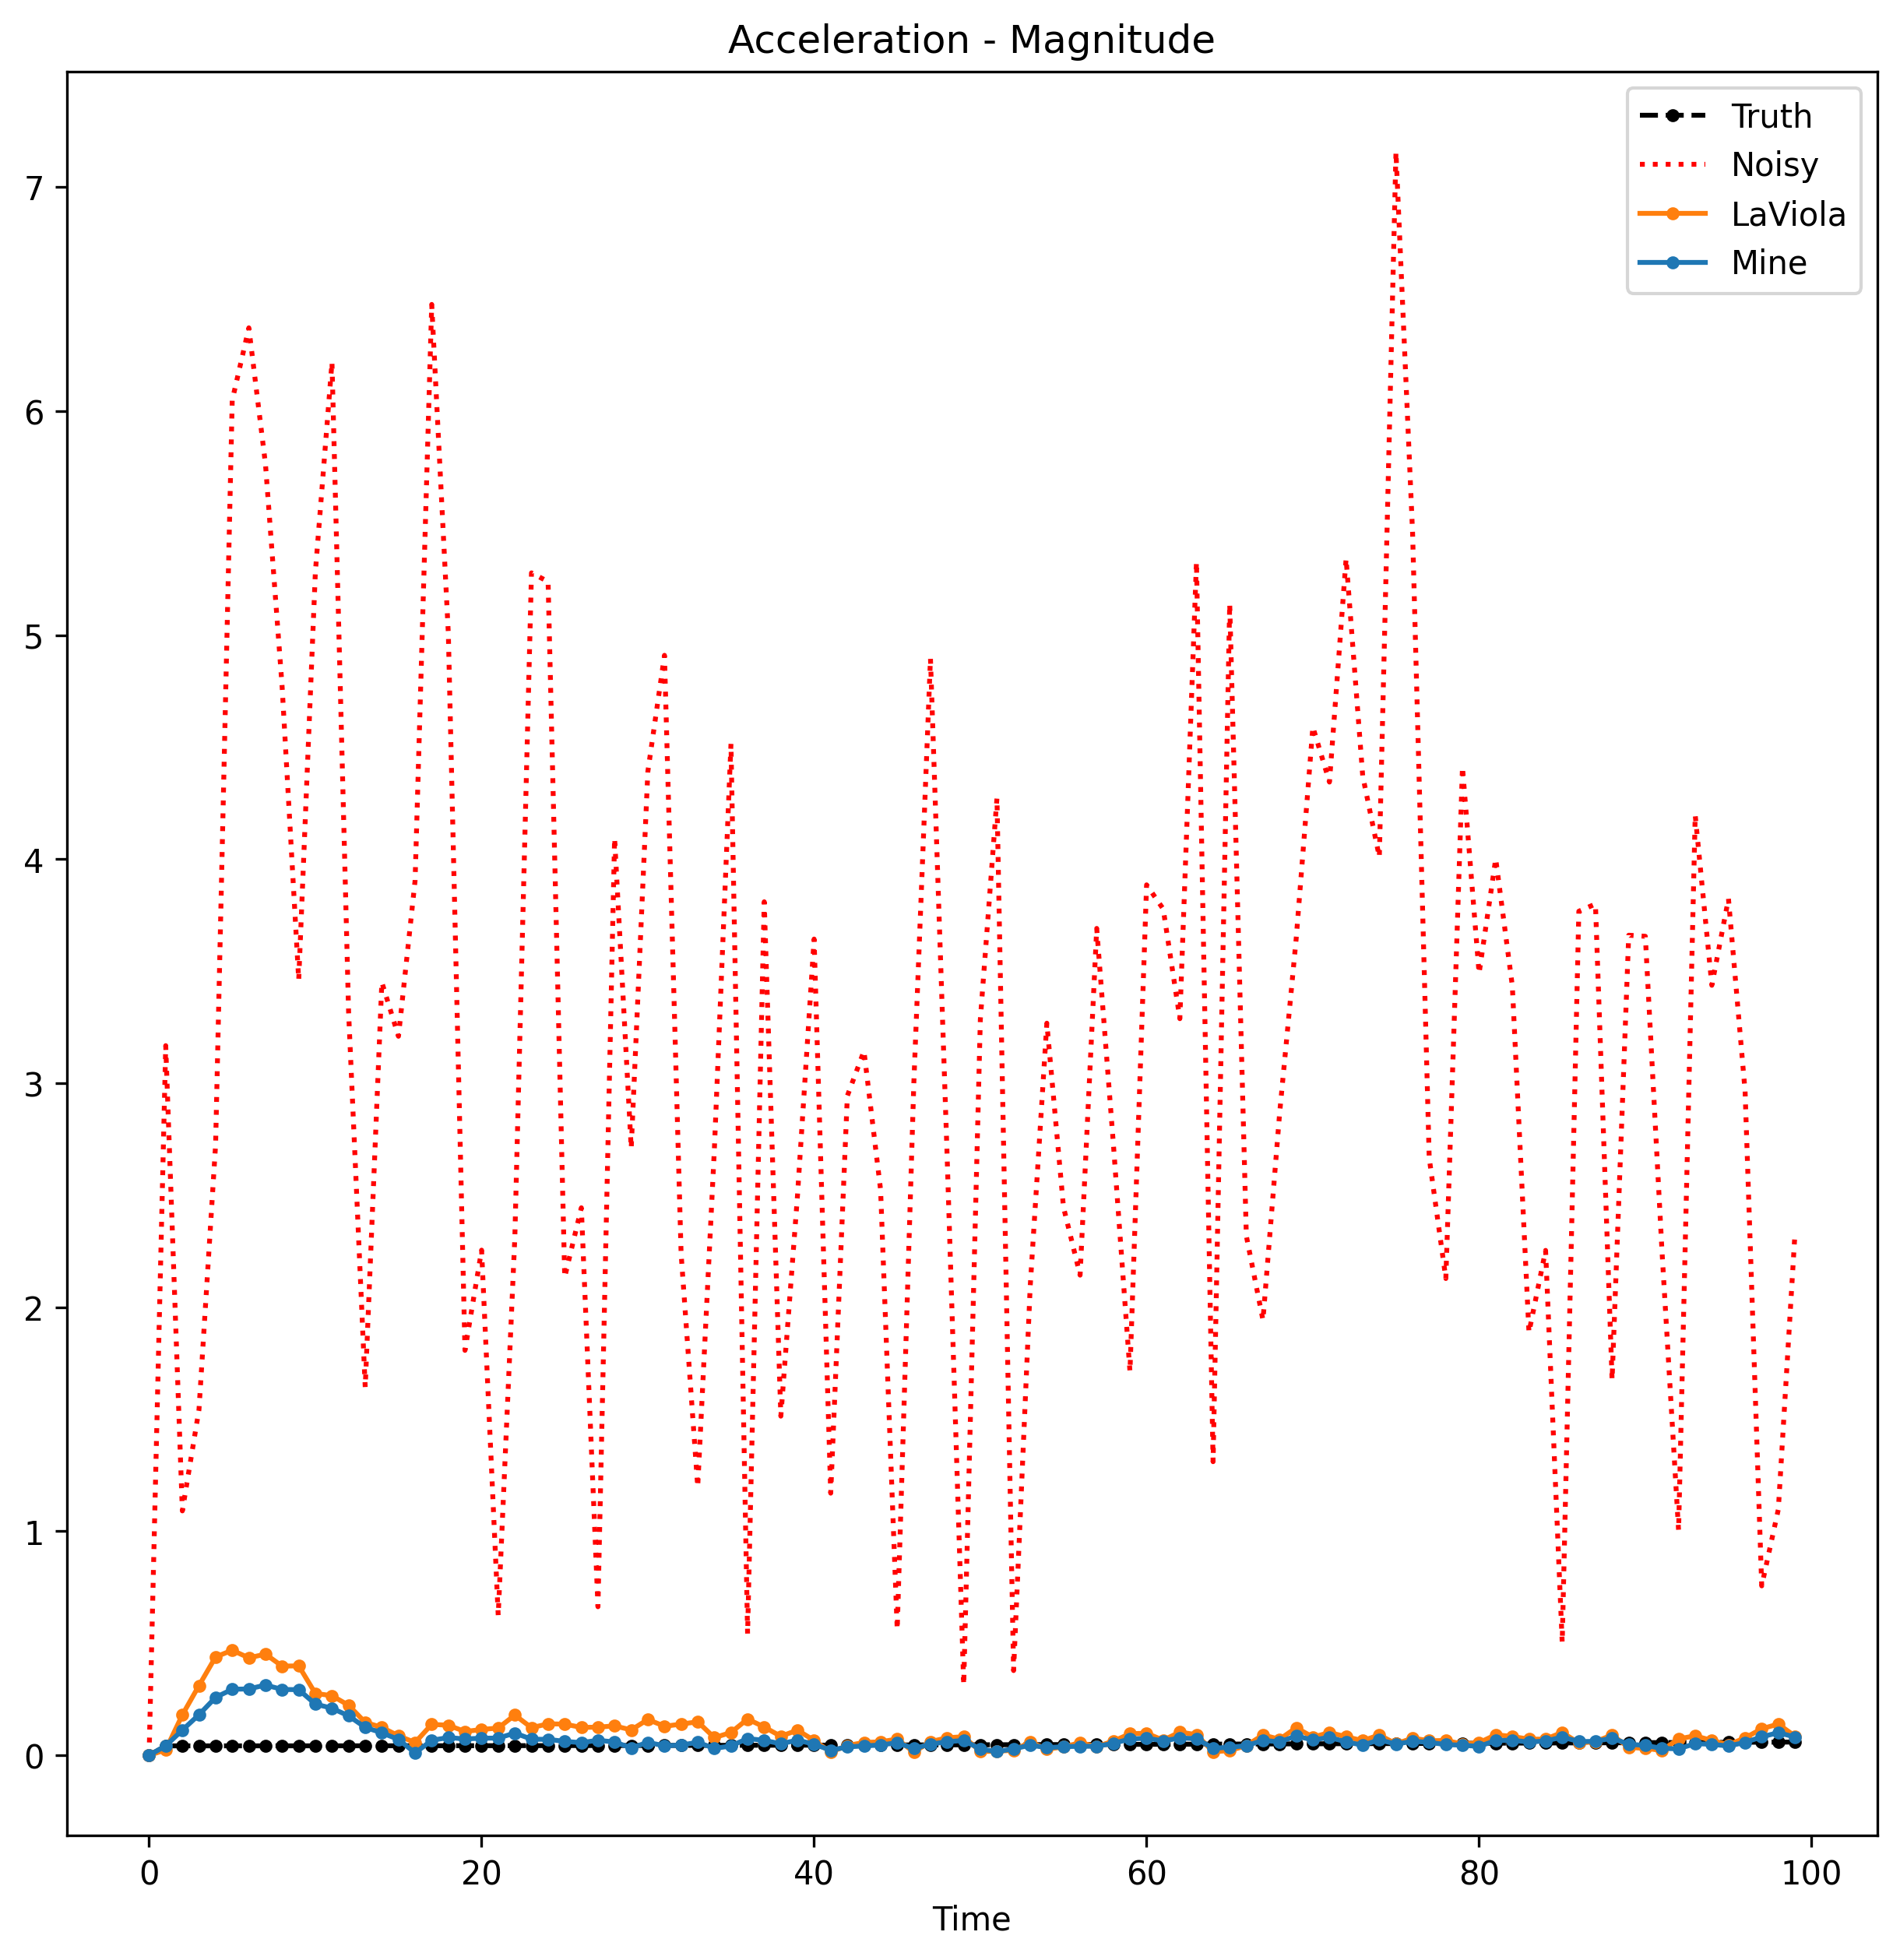

In [40]:
from typing import List
from shared import Vec2
import matplotlib.pyplot as plt
import numpy as np

figsize=(10, 10)
dpi = 300.

def bezier(start: Vec2, end: Vec2, c1: Vec2, c2: Vec2, samples: int) -> List[Vec2]:
    points: List[Vec2] = []
    for i in range(samples):
        t = i / samples
        s = 1.0 - t
        points.append(
            s ** 3 * start + 3 * s ** 2 * t * c1 + 3 * s * t ** 2 * c2 + t ** 3 * p2
        )
    return points


def draw_path(path: List[Vec2], style: str = ".-k", label: str = None, *, plot=None):
    _path = np.array(path)
    xpath = _path[:, 0]
    ypath = _path[:, 1]

    if plot is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        plot = fig.add_subplot()
        plot.axhline(0, color='lightgrey')
        plot.axvline(0, color='lightgrey')
        plot.set_ylabel('Y')
        plot.set_xlabel('X')
    plot.plot(xpath, ypath, style, label=label)
    return plot

def draw_line(path: List[float], style: str = ".-k", label: str = None, *, plot=None):
    xpath = np.array(path)

    if plot is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        plot = fig.add_subplot()
        plot.set_xlabel('Time')
    plot.plot(xpath, style, label=label)
    return plot


def velocity(path: List[Vec2]):
    v = [Vec2(0, 0)]
    for i in range(len(path) - 1):
        v.append(path[i + 1] - path[i])
    return v


def noisy(path: List[Vec2], scale: float = 1):
    noise = np.random.normal(loc=0, scale=scale, size=(len(path), 2))
    return [(p + n).view(Vec2) for p, n in zip(path, noise)]


def laviola(path: List[Vec2], k: float = 0.85, out=''):
    p = [path[0]] + [None] * (len(path) - 1)
    v = [Vec2(0, 0)] + [None] * (len(path) - 1)
    _out = [path[0]] + [None] * (len(path) - 1)

    for i in range(1, len(path)):
        observed = path[i]

        p[i] = k * p[i - 1] + (1 - k) * observed
        v[i] = k * v[i - 1] + (1 - k) * p[i]
        _out[i] = (2 + (1 - k) / k) * p[i] - (1 + (1 - k) / k) * v[i]

    return _out


def ewma(path: List[Vec2], k: float = 0.85, out=''):

    p = [path[0]] + [None] * (len(path) - 1)

    for i in range(1, len(path)):
        observed = path[i]
        p[i] = k * p[i-1] + (1 - k) * observed
    return p


def smooth(path: List[Vec2], k: float = 0.85, out=''):
    k_correction = k / (1 - k)

    p = [path[0]] + [None] * (len(path) - 1)
    v = [Vec2(0, 0)] + [None] * (len(path) - 1)
    a = [Vec2(0, 0)] + [None] * (len(path) - 1)
    _out = [path[0]] + [None] * (len(path) - 1)

    for i in range(1, len(path)):
        observed = path[i]

        p_pred = p[i - 1] + v[i - 1] + a[i - 1] * 0.5
        p[i] = k * p_pred + (1 - k) * observed
        v_pred = v[i - 1] + a[i - 1]
        v[i] = k * v_pred + (1 - k) * (p[i] - p_pred)
        a[i] = k * a[i - 1] + (1 - k) * (v[i] - v_pred)
        _out[i] = p[i] + v[i] * k_correction + 0.5 * a[i] * k_correction * k_correction
        
    if out == 'v':
        return [(v_ + a_ * k_correction) * 2 for v_, a_ in zip(v, a)]

    if out == 'a':
        return [a_ * 4 for a_ in a]

    return _out


def kalman(path: List[Vec2]):
    pass

def __sq_mag(v: Vec2):
    return v.dot(v)

sq_mag = np.vectorize(__sq_mag, signature='(v)->()')

p1 = Vec2(0, 0)
p2 = Vec2(100, 100)
c1 = Vec2(0, 100)
c2 = Vec2(50, 150)

path = bezier(p1, p2, c1, c2, 100)
noise = noisy(path, 1)
sm1 = ewma(noise)
sm2 = smooth(noise)
viola = laviola(noise)

fig_path = draw_path(path, ".--k", "Truth")
draw_path(noise, ":r", "Noisy", plot=fig_path)
draw_path(sm1, ".-C2", "EWMA", plot=fig_path)

plt.title('Position')
plt.legend()
plt.show()

fig_path = draw_path(path, ".--k", "Truth")
draw_path(noise, ":r", "Noisy", plot=fig_path)
draw_path(viola, ".-C1", "LaViola", plot=fig_path)
draw_path(sm2, ".-C0", "Mine", plot=fig_path)

plt.title('Position')
plt.legend()
plt.show()


err_path = [sq_mag(p - n) for p, n in zip(path, path)]
err_noise = [sq_mag(p - n) for p, n in zip(path, noise)]
err_sm1 = [sq_mag(p - n) for p, n in zip(path, sm1)]
err_viola = [sq_mag(p - n) for p, n in zip(path, viola)]
err_sm2 = [sq_mag(p - n) for p, n in zip(path, sm2)]

fig_noise = draw_line(err_path, ".--k", "Truth")
draw_line(err_noise, ":r", "Noisy", plot=fig_noise)
draw_line(err_sm1, ".-C2", "EWMA", plot=fig_noise)

plt.title('Position - Square Error')
plt.legend()
plt.show()

fig_noise = draw_line(err_path, ".--k", "Truth")
draw_line(err_noise, ":r", "Noisy", plot=fig_noise)
draw_line(err_viola, ".-C1", "LaViola", plot=fig_noise)
draw_line(err_sm2, ".-C0", "Mine", plot=fig_noise)

plt.title('Position - Square Error')
plt.legend()
plt.show()

print(f'AVG SQUARE ERROR')
print(f'NOISE: {np.mean(err_noise)}')
print(f'EWMA: {np.mean(err_sm1)}')
print(f'LAVIOLA: {np.mean(err_viola)}')
print(f'MINE: {np.mean(err_sm2)}')
print()
print(f'AVG SQUARE ERROR AFTER STABLE')
print(f'NOISE: {np.mean(err_noise[10:])}')
print(f'EWMA: {np.mean(err_sm1[10:])}')
print(f'LAVIOLA: {np.mean(err_viola[10:])}')
print(f'MINE: {np.mean(err_sm2[10:])}')


vel = velocity(path)
v_noise = velocity(noise)
v_sm1 = ewma(velocity(sm1))
v_viola = laviola(velocity(viola))
v_sm2 = smooth(noise, out='v')

fig_vel = draw_path(vel, ".--k", "Truth")
draw_path(v_noise, ":r", "Noisy", plot=fig_vel)
draw_path(v_sm1, ".-C2", "EWMA", plot=fig_vel)

plt.title('Velocity')
plt.legend()
plt.show()

fig_vel = draw_path(vel, ".--k", "Truth")
draw_path(v_viola, ".-C1", "LaViola", plot=fig_vel)
draw_path(v_sm2, ".-C0", "Mine", plot=fig_vel)

plt.title('Velocity')
plt.legend()
plt.show()

err_path = [sq_mag(p - n) for p, n in zip(vel, vel)]
err_noise = [sq_mag(p - n) for p, n in zip(vel, v_noise)]
err_sm1 = [sq_mag(p - n) for p, n in zip(vel, v_sm1)]
err_viola = [sq_mag(p - n) for p, n in zip(vel, v_viola)]
err_sm2 = [sq_mag(p - n) for p, n in zip(vel, v_sm2)]

fig_noise = draw_line(err_path, ".--k", "Truth")
draw_line(err_noise, ":r", "Noisy", plot=fig_noise)
draw_line(err_sm1, ".-C2", "EWMA", plot=fig_noise)

plt.title('Velocity - Square Error')
plt.legend()
plt.show()

fig_noise = draw_line(err_path, ".--k", "Truth")
draw_line(err_viola, ".-C1", "LaViola", plot=fig_noise)
draw_line(err_sm2, ".-C0", "Mine", plot=fig_noise)

plt.title('Velocity - Square Error')
plt.legend()
plt.show()

print(f'AVG SQUARE ERROR')
print(f'NOISE: {np.mean(err_noise)}')
print(f'EWMA: {np.mean(err_sm1)}')
print(f'LAVIOLA: {np.mean(err_viola)}')
print(f'MINE: {np.mean(err_sm2)}')

vel = velocity(velocity(path))
vel[1] = vel[2]
a_noise = velocity(velocity(noise))
a_viola = laviola(velocity(v_viola))
v_sm2 = smooth(noise, out='a')

# fig_vel = draw_path(vel, ".--k", "velocity")
# # draw_path(a_noise, ":r", "noise", plot=fig_vel)
# draw_path(a_viola, ".-C1", "a_viola", plot=fig_vel)
# draw_path(v_sm2, ".-C0", "smooth", plot=fig_vel)
# plt.title('Acceleration')
# plt.legend()
# plt.show()

fig_vel = draw_line(np.sqrt(sq_mag(vel)), ".--k", "Truth")
draw_line(np.sqrt(sq_mag(a_noise)), ":r", "Noisy", plot=fig_vel)
draw_line(np.sqrt(sq_mag(a_viola)), ".-C1", "LaViola", plot=fig_vel)
draw_line(np.sqrt(sq_mag(v_sm2)), ".-C0", "Mine", plot=fig_vel)
 
plt.title('Acceleration - Magnitude')
plt.legend()
plt.show()